In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')
import dask.dataframe as dd
import missingno as msno
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
import matplotlib.gridspec as gridspec
from sklearn import preprocessing

In [2]:
#Always seed the randomness of this universe
np.random.seed(51)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
%%time
train_metadata_kaggle = dd.read_csv('mydata_train_metadata.csv')
test_metadata_kaggle = dd.read_csv('mydata_test_metadata.csv')
train_metadata_kaggle = train_metadata_kaggle.compute()
test_metadata_kaggle = test_metadata_kaggle.compute()
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 93) (3492890, 92)
CPU times: user 2min 1s, sys: 6.52 s, total: 2min 7s
Wall time: 22.4 s


In [5]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [6]:
%%time
final_dict = {}

loss_list = []
temp = train_metadata_kaggle.copy()
#temp = temp.merge(train_metadata[['object_id',column_]],on = 'object_id',how = 'left')
y = temp['target']
del temp['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

#print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
clfs = []
importances = pd.DataFrame()
lgb_params = {
'random_state':51,
'device': 'cpu', 
'objective': 'multiclass', 
'num_class': 14, 
'boosting_type': 'gbdt', 
'n_jobs': -1, 
'max_depth': 7, 
'n_estimators': 1000, 
'subsample_freq': 2, 
'subsample_for_bin': 5000, 
'min_data_per_group': 100, 
'max_cat_to_onehot': 4, 
'cat_l2': 1.0, 
'cat_smooth': 59.5, 
'max_cat_threshold': 32, 
'metric_freq': 10, 
'verbosity': -1, 
'metric': 'multi_logloss', 
'xgboost_dart_mode': False, 
'uniform_drop': False, 
'colsample_bytree': 0.5, 
'drop_rate': 0.173, 
'learning_rate': 0.0267, 
'max_drop': 5, 
'min_child_samples': 10, 
'min_child_weight': 100.0, 
'min_split_gain': 0.1, 
'num_leaves': 7, 
'reg_alpha': 0.1, 
'reg_lambda': 0.00023, 
'skip_drop': 0.44, 
'subsample': 0.75}
oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
    val_x, val_y = temp.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=False,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
    #loss_list.append(loss_oof)
    print(fold_,loss_oof)

    imp_df = pd.DataFrame()
    imp_df['feature'] = temp.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
#final_dict[column_] = loss_list

0 0.6306725280126511
1 0.5988910655279867
2 0.6664656365700714
3 0.6026603016468189
4 0.6125772357651881
MULTI WEIGHTED LOG LOSS : 0.62228 
CPU times: user 8min 55s, sys: 828 ms, total: 8min 56s
Wall time: 1min 10s


In [7]:
dropped_list = [x for x in train_metadata_kaggle.columns if x not in ['target','object_id']]

In [8]:
%%time
final_dict = {}

for column_ in dropped_list:
    loss_list = []
    temp = train_metadata_kaggle.copy()
    temp.drop([column_],axis=1,inplace=True)
    y = temp['target']
    del temp['target']
    classes = sorted(y.unique())

    # Taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    class_weight = {
        c: 1 for c in classes
    }
    for c in [64, 15]:
        class_weight[c] = 2

    #print('Unique classes : ', classes)

    train_id = temp['object_id']
    del temp['object_id']
    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
    'random_state':51,
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 500, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75}
    oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
        val_x, val_y = temp.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=False,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights)
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
        loss_list.append(loss_oof)
        #print(column_,fold_,loss_oof)

        imp_df = pd.DataFrame()
        imp_df['feature'] = temp.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)
    print(column_,'MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
    final_dict[column_] = loss_list

flux_min MULTI WEIGHTED LOG LOSS : 0.62386 
flux_max MULTI WEIGHTED LOG LOSS : 0.62304 
flux_mean MULTI WEIGHTED LOG LOSS : 0.62278 
flux_median MULTI WEIGHTED LOG LOSS : 0.62623 
flux_std MULTI WEIGHTED LOG LOSS : 0.62331 
flux_skew MULTI WEIGHTED LOG LOSS : 0.62595 
flux_err_min MULTI WEIGHTED LOG LOSS : 0.62659 
flux_err_max MULTI WEIGHTED LOG LOSS : 0.62490 
flux_err_mean MULTI WEIGHTED LOG LOSS : 0.62448 
flux_err_median MULTI WEIGHTED LOG LOSS : 0.62325 
flux_err_std MULTI WEIGHTED LOG LOSS : 0.62338 
flux_err_skew MULTI WEIGHTED LOG LOSS : 0.62466 
detected_mean MULTI WEIGHTED LOG LOSS : 0.62438 
flux_ratio_sq_sum MULTI WEIGHTED LOG LOSS : 0.62419 
flux_ratio_sq_skew MULTI WEIGHTED LOG LOSS : 0.62337 
flux_by_flux_ratio_sq_sum MULTI WEIGHTED LOG LOSS : 0.62432 
flux_by_flux_ratio_sq_skew MULTI WEIGHTED LOG LOSS : 0.62442 
flux_w_mean MULTI WEIGHTED LOG LOSS : 0.62550 
flux_diff1 MULTI WEIGHTED LOG LOSS : 0.62388 
flux_diff2 MULTI WEIGHTED LOG LOSS : 0.62501 
flux_diff3 MULTI WEI

In [9]:
final_dict2 = pd.Series(final_dict)
final_dict2 = pd.DataFrame(final_dict2)
final_dict2['fold1'] = final_dict2[0].apply(lambda x: x[0])
final_dict2['fold2'] = final_dict2[0].apply(lambda x: x[1])
final_dict2['fold3'] = final_dict2[0].apply(lambda x: x[2])
final_dict2['fold4'] = final_dict2[0].apply(lambda x: x[3])
final_dict2['fold5'] = final_dict2[0].apply(lambda x: x[4])

del final_dict2[0]

final_dict2 = final_dict2.reset_index(drop=False)

final_dict2 = final_dict2.rename(columns={'index':'column_name'})

final_dict2['fold1_1'] = (final_dict2['fold1'] > 0.63067) * 1
final_dict2['fold2_1'] = (final_dict2['fold2'] > 0.59889) * 1
final_dict2['fold3_1'] = (final_dict2['fold3'] > 0.66646) * 1
final_dict2['fold4_1'] = (final_dict2['fold4'] > 0.60266) * 1
final_dict2['fold5_1'] = (final_dict2['fold5'] > 0.61257) * 1
final_dict2['fold_sum'] = final_dict2['fold1_1']+ final_dict2['fold2_1'] + final_dict2['fold3_1'] + final_dict2['fold4_1'] + final_dict2['fold5_1']


In [10]:
final_dict2.head()

column_name     fold1     fold2     fold3     fold4     fold5  fold1_1  \
0     flux_min  0.632743  0.598580  0.673786  0.604110  0.610019        1   
1     flux_max  0.634733  0.593494  0.674112  0.602926  0.609907        1   
2    flux_mean  0.630043  0.597122  0.672656  0.603349  0.610715        0   
3  flux_median  0.635831  0.602184  0.677274  0.603279  0.612503        1   
4     flux_std  0.634339  0.597778  0.670637  0.604663  0.608988        1   

   fold2_1  fold3_1  fold4_1  fold5_1  fold_sum  
0        0        1        1        0         3  
1        0        1        1        0         3  
2        0        1        1        0         2  
3        1        1        1        0         4  
4        0        1        1        0         3

In [11]:
final_dict2.to_csv('final_features.csv',index=False)

In [12]:
%%time
train_metadata = dd.read_csv('train_myoutput.csv')
test_metadata = dd.read_csv('test_myoutput.csv')
train_metadata = train_metadata.compute()
test_metadata = test_metadata.compute()
print(train_metadata.shape,test_metadata.shape)

(7848, 90) (3492890, 89)
CPU times: user 1min 48s, sys: 5.79 s, total: 1min 54s
Wall time: 19.7 s


In [13]:
train_metadata.head()

object_id        ra       decl     gal_l     gal_b  ddf  hostgal_photoz  \
0        615  0.969557   0.673682  0.890941  0.574262    1        0.000000   
1        713  0.147044   8.842809  0.620702  0.533204    1        0.679954   
2        730  0.092819  13.913876  0.473262  0.425706    1        0.094551   
3        745  0.000039   4.585453  0.911661  0.313148    1        0.117582   
4       1124  0.979744   0.224128  0.880178  0.584793    1        0.100946   

   hostgal_photoz_err   distmod     mwebv  target     leavg     lestd  \
0            0.000000  0.000000  1.716561      92  0.367218  0.749418   
1            0.209284  0.965566  0.838486      88  0.960611  0.213946   
2            0.012875  0.856046  1.925672      42  0.656940  0.072124   
3            0.944978  0.867508  0.838486      90  1.021002  0.095485   
4            0.014433  0.859460  2.057815      90  0.761852  0.079376   

      lemed     lemfl     lesfl     lemax     ledsl     lemin     lersl  \
0  0.377550  0.264274  0.915871  1.186008  0.431278  0.432572  1.855552   
1  1.058979  0.017125  0.792887  0.831106  1.149591  1.138391  1.128085   
2  0.711667  0.043192  0.844469  0.658834  1.242174  1.232450  1.035636   
3  1.138718  0.003074  0.838895  0.698338  1.381036  1.181234  0.896974   
4  0.856350  0.047877  0.851406  0.682397  1.489406  1.185845  0.788761   

      heavg     hestd     hemed     hemfl     hesfl     hemax     hedsl  \
0  0.464892  0.576553  0.380371  0.062189  0.141927  0.820327  0.342725   
1  1.025805  0.082898  1.019587  0.002797  0.167623  0.499451  1.107997   
2  0.978976  0.091184  1.016489  0.028617  0.105791  0.497219  1.123252   
3  0.950050  0.088108  0.869748  0.018055  0.148716  0.502734  1.160181   
4  1.239698  0.095741  0.950943  0.036811  0.162019  0.491777  1.146786   

      hemin     hersl     lmavg     lmstd     lmmed     lmmfl     lmsfl  \
0  1.301038  0.800552  0.423993  0.771304  0.422379  0.264653  0.442064   
1  2.314684  0.604746  0.701382  0.244678  0.733772  0.036893  0.404617   
2  2.230497  0.664530  0.918478  0.145268  0.981610  0.048640  0.394245   
3  2.289767  0.556268  1.114981  0.535460  1.160204  0.018975  0.400172   
4  2.274372  0.568711  0.650563  0.130556  0.731502  0.043202  0.431322   

      lmmax     lmdsl     lmmin     lmrsl     hmavg     hmstd     hmmed  \
0  1.124564  0.911592  0.450530  1.658744  0.946460  0.557092  0.921308   
1  0.747282  1.188099  1.098708  0.809151  0.837241  0.124637  0.785390   
2  0.657440  0.885919  1.187092  1.247504  0.715178  0.123954  0.710529   
3  1.037849  0.830995  1.592998  1.227352  1.091163  0.306529  1.101003   
4  0.656791  1.020160  1.253987  1.005823  0.960891  0.082475  0.857269   

      hmmfl     hmsfl     hmmax     hmdsl     hmmin     hmrsl     llavg  \
0  0.046446  0.264155  0.803462  0.360976  1.380625  0.974178  0.558262   
1  0.009717  0.149475  0.510584  1.099764  2.335214  0.898123  0.678141   
2  0.021879  0.264068  0.469126  0.910688  2.222513  1.077681  1.029846   
3  0.010034  0.289854  0.714691  0.990543  3.630944  1.001846  0.661092   
4  0.013437  0.270054  0.482597  0.901913  2.427697  1.086015  1.145873   

      llstd     llmed     llmfl     llsfl     llmax     lldsl     llmin  \
0  0.770807  1.334543  0.237991  0.584895  1.208633  0.451811  0.407419   
1  0.173192  0.761128  0.014237  0.532073  0.510462  1.123423  0.919886   
2  0.324415  1.115434  0.004418  0.509298  0.913485  1.100752  1.106755   
3  0.172586  1.189519  0.023345  0.512444  0.800348  1.075083  1.112832   
4  0.470323  1.230329  0.080626  0.568040  1.057585  0.934170  1.426000   

      llrsl     hlavg     hlstd     hlmed     hlmfl     hlsfl     hlmax  \
0  1.885749  1.175079  0.577139  1.272129  0.070072  0.118565  0.811806   
1  0.928880  0.704977  0.066137  0.749123  0.002445  0.137496  0.153697   
2  0.969224  1.115398  0.244734  1.165928  0.015704  0.127915  0.625662   
3  1.240741  0.780153  0.113672  0.684755  0.027680  0.519170  0.487101   
4  1.164576  1

In [14]:
bool_columns = ['highEnergy_transitory_1.0_TF',
                'highEnergy_transitory_1.5_TF',
               'lowEnergy_transitory_1.0_TF',
               'lowEnergy_transitory_1.5_TF']

In [15]:
train_metadata['highEnergy_transitory_1.0_TF'].head()*1

0    0
1    1
2    0
3    0
4    0
Name: highEnergy_transitory_1.0_TF, dtype: int64

In [16]:
used_columns = [x for x in train_metadata.columns if x not in train_metadata_kaggle.columns]

In [17]:
%%time
#COnverting bool to int
for i in bool_columns:
    train_metadata[i] = train_metadata[i] * 1
    test_metadata[i] = test_metadata[i] * 1

CPU times: user 50.6 ms, sys: 28 ms, total: 78.6 ms
Wall time: 78 ms


In [18]:
%%time
final_dict = {}

for column_ in used_columns:
    loss_list = []
    temp = train_metadata_kaggle.copy()
    temp = temp.merge(train_metadata[['object_id',column_]],on = 'object_id',how = 'left')
    y = temp['target']
    del temp['target']
    classes = sorted(y.unique())

    # Taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    class_weight = {
        c: 1 for c in classes
    }
    for c in [64, 15]:
        class_weight[c] = 2

    #print('Unique classes : ', classes)

    train_id = temp['object_id']
    del temp['object_id']
    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
    'random_state':51,
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 500, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75}
    oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
        val_x, val_y = temp.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=False,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights)
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
        loss_list.append(loss_oof)
        #print(column_,fold_,loss_oof)

        imp_df = pd.DataFrame()
        imp_df['feature'] = temp.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)
    print(column_,'MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
    final_dict[column_] = loss_list

ra MULTI WEIGHTED LOG LOSS : 0.62398 
decl MULTI WEIGHTED LOG LOSS : 0.62314 
gal_l MULTI WEIGHTED LOG LOSS : 0.62472 
gal_b MULTI WEIGHTED LOG LOSS : 0.62357 
ddf MULTI WEIGHTED LOG LOSS : 0.62328 
leavg MULTI WEIGHTED LOG LOSS : 0.62386 
lestd MULTI WEIGHTED LOG LOSS : 0.62367 
lemed MULTI WEIGHTED LOG LOSS : 0.62455 
lemfl MULTI WEIGHTED LOG LOSS : 0.62367 
lesfl MULTI WEIGHTED LOG LOSS : 0.62394 
lemax MULTI WEIGHTED LOG LOSS : 0.62472 
ledsl MULTI WEIGHTED LOG LOSS : 0.62368 
lemin MULTI WEIGHTED LOG LOSS : 0.62427 
lersl MULTI WEIGHTED LOG LOSS : 0.62491 
heavg MULTI WEIGHTED LOG LOSS : 0.62419 
hestd MULTI WEIGHTED LOG LOSS : 0.62326 
hemed MULTI WEIGHTED LOG LOSS : 0.62415 
hemfl MULTI WEIGHTED LOG LOSS : 0.62284 
hesfl MULTI WEIGHTED LOG LOSS : 0.62324 
hemax MULTI WEIGHTED LOG LOSS : 0.62338 
hedsl MULTI WEIGHTED LOG LOSS : 0.62374 
hemin MULTI WEIGHTED LOG LOSS : 0.62390 
hersl MULTI WEIGHTED LOG LOSS : 0.62381 
lmavg MULTI WEIGHTED LOG LOSS : 0.62392 
lmstd MULTI WEIGHTED L

In [19]:
final_dict2 = pd.Series(final_dict)
final_dict2 = pd.DataFrame(final_dict2)
final_dict2['fold1'] = final_dict2[0].apply(lambda x: x[0])
final_dict2['fold2'] = final_dict2[0].apply(lambda x: x[1])
final_dict2['fold3'] = final_dict2[0].apply(lambda x: x[2])
final_dict2['fold4'] = final_dict2[0].apply(lambda x: x[3])
final_dict2['fold5'] = final_dict2[0].apply(lambda x: x[4])

del final_dict2[0]

final_dict2 = final_dict2.reset_index(drop=False)

final_dict2 = final_dict2.rename(columns={'index':'column_name'})

final_dict2['fold1_1'] = (final_dict2['fold1'] > 0.63067) * 1
final_dict2['fold2_1'] = (final_dict2['fold2'] > 0.59889) * 1
final_dict2['fold3_1'] = (final_dict2['fold3'] > 0.66646) * 1
final_dict2['fold4_1'] = (final_dict2['fold4'] > 0.60266) * 1
final_dict2['fold5_1'] = (final_dict2['fold5'] > 0.61257) * 1
final_dict2['fold_sum'] = final_dict2['fold1_1']+ final_dict2['fold2_1'] + final_dict2['fold3_1'] + final_dict2['fold4_1'] + final_dict2['fold5_1']



In [20]:
final_dict2.head()

column_name     fold1     fold2     fold3     fold4     fold5  fold1_1  \
0          ra  0.635857  0.596731  0.672728  0.603299  0.611059        1   
1        decl  0.632038  0.597223  0.671606  0.603551  0.611123        1   
2       gal_l  0.636452  0.598316  0.670506  0.606651  0.611427        1   
3       gal_b  0.634370  0.596335  0.670899  0.604371  0.611679        1   
4         ddf  0.633678  0.596496  0.671590  0.601973  0.612490        1   

   fold2_1  fold3_1  fold4_1  fold5_1  fold_sum  
0        0        1        1        0         3  
1        0        1        1        0         3  
2        0        1        1        0         3  
3        0        1        1        0         3  
4        0        1        0        0         2

In [21]:
final_dict2.to_csv('final_features2.csv',index=False)

# Feature Importances

In [22]:
temp = train_metadata_kaggle.copy()
temp = temp.merge(train_metadata[used_columns + ['object_id']],on = 'object_id',how = 'left')

In [26]:
def get_feature_importances(data, shuffle):
    # Gather real features
    train_features = [f for f in data if f not in ['target', 'object_id']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    y = pd.Series(y)
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
        y = le.fit_transform(y)
        y = pd.Series(y)
    
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    lgb_params = {
    'random_state':51,
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 250, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75}
    # Fit the model
    """clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        data[train_features], y,
        eval_metric=lgb_multi_weighted_logloss,
        verbose=False,
        sample_weight=y.map(weights)
    )"""
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(pd.get_dummies(y), clf.predict_proba(data[train_features]))
    
    return imp_df

In [27]:
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=temp, shuffle=False)

In [28]:
null_imp_df = pd.DataFrame()
nb_runs = 150
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=temp, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with    1 of  150 (Spent   0.1 miDone with    2 of  150 (Spent   0.1 miDone with    3 of  150 (Spent   0.2 miDone with    4 of  150 (Spent   0.2 miDone with    5 of  150 (Spent   0.3 miDone with    6 of  150 (Spent   0.3 miDone with    7 of  150 (Spent   0.4 miDone with    8 of  150 (Spent   0.6 miDone with    9 of  150 (Spent   0.6 miDone with   10 of  150 (Spent   0.7 miDone with   11 of  150 (Spent   0.7 miDone with   12 of  150 (Spent   0.8 miDone with   13 of  150 (Spent   0.9 miDone with   14 of  150 (Spent   0.9 miDone with   15 of  150 (Spent   1.0 miDone with   16 of  150 (Spent   1.0 miDone with   17 of  150 (Spent   1.1 miDone with   18 of  150 (Spent   1.1 miDone with   19 of  150 (Spent   1.2 miDone with   20 of  150 (Spent   1.3 miDone with   21 of  150 (Spent   1.3 miDone with   22 of  150 (Spent   1.4 miDone with   23 of  150 (Spent   1.5 miDone with   24 of  150 (Spent   1.5 miDone with   25 of  150 (Spent   1.6 miDone with   26 of  150 (Spent   1.7 miDone with   

In [32]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
    plt.show()

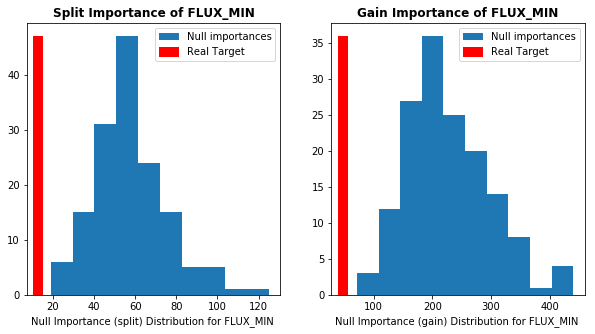

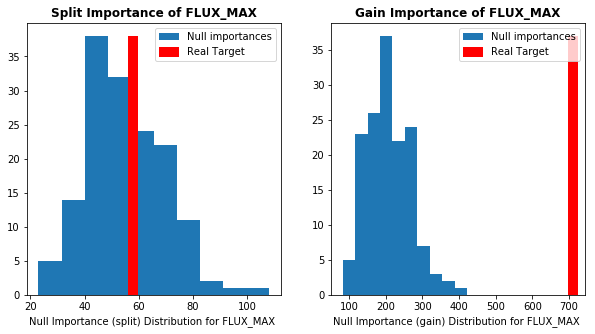

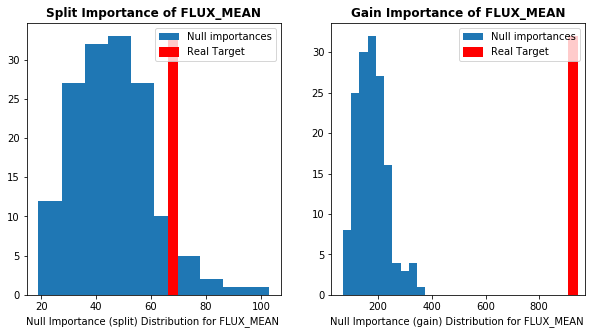

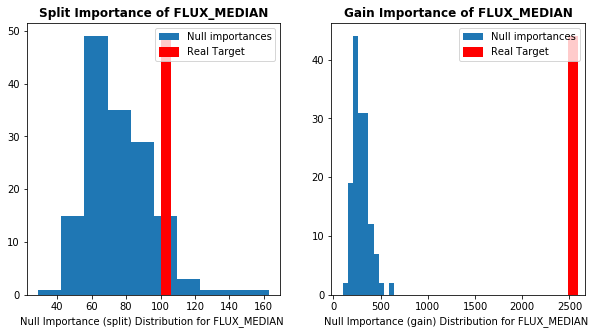

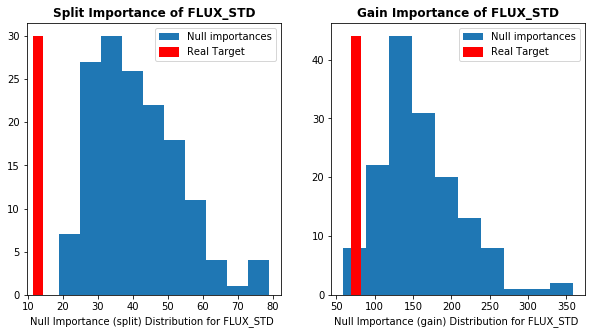

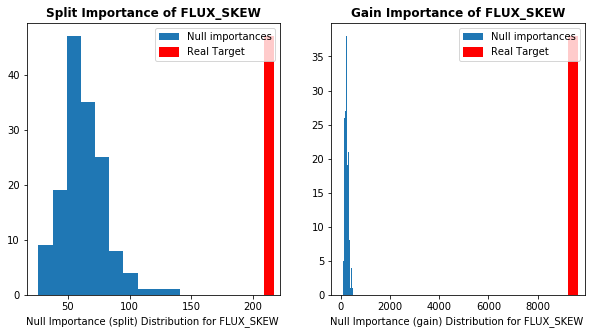

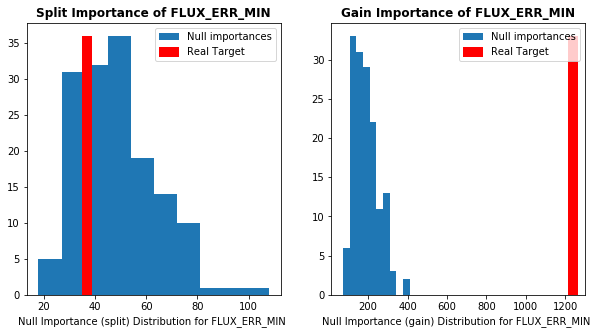

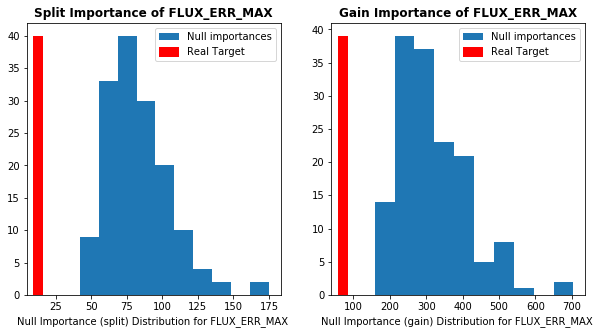

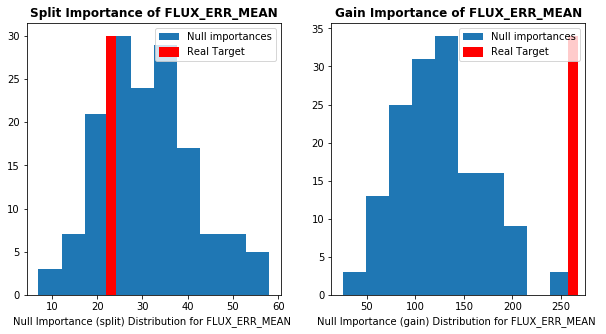

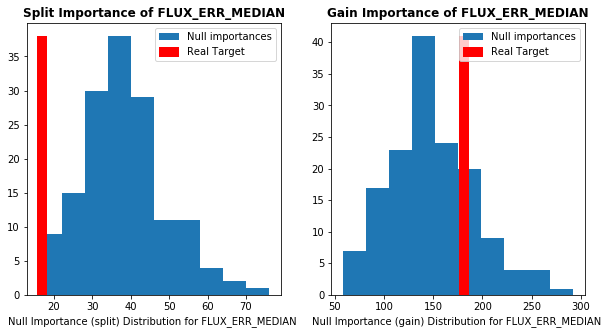

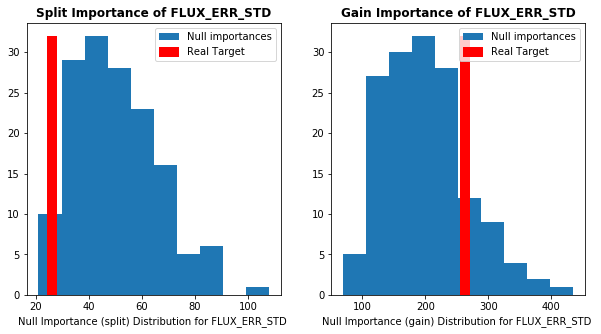

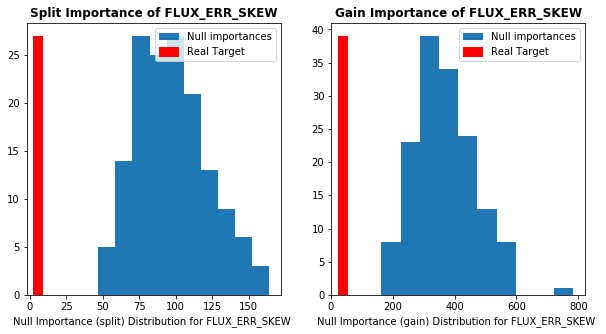

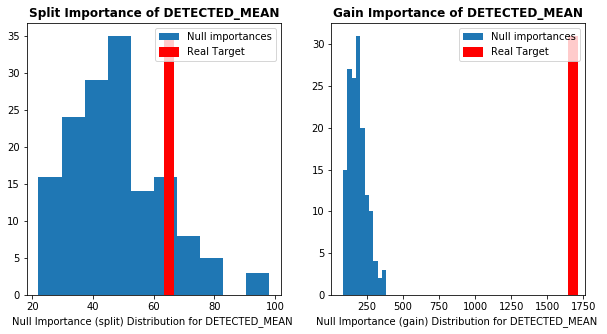

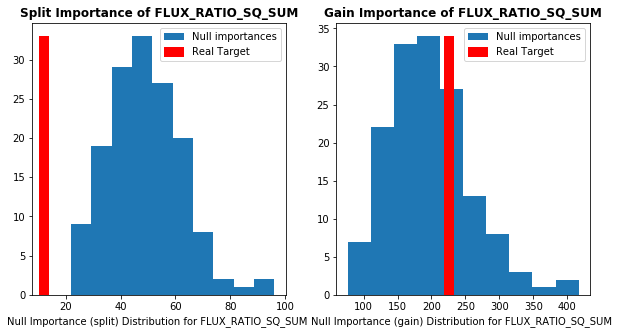

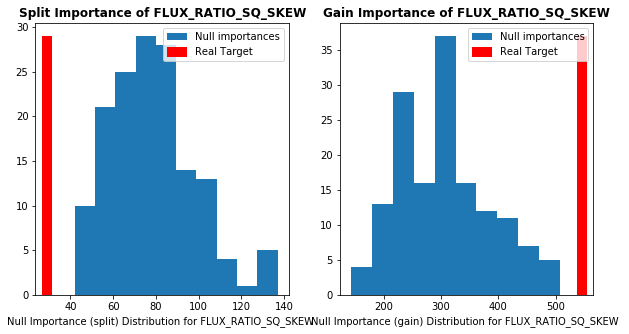

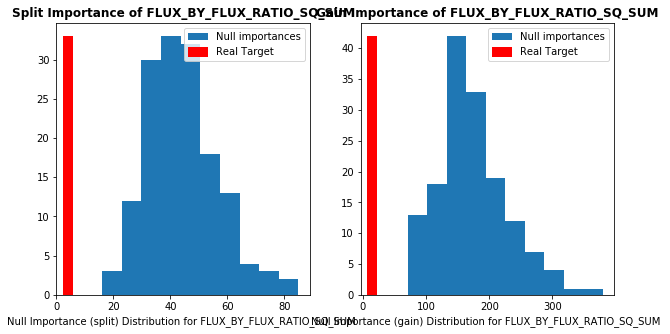

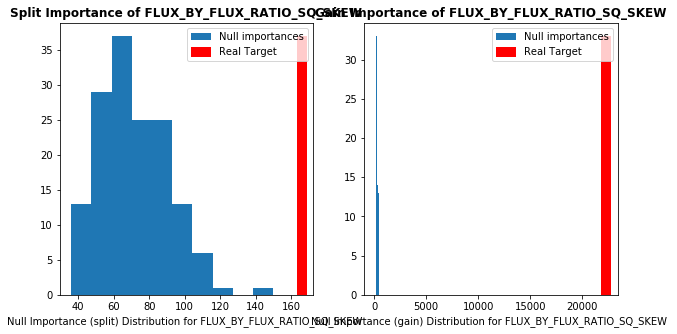

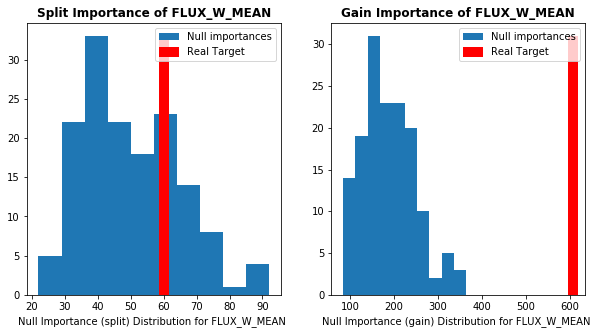

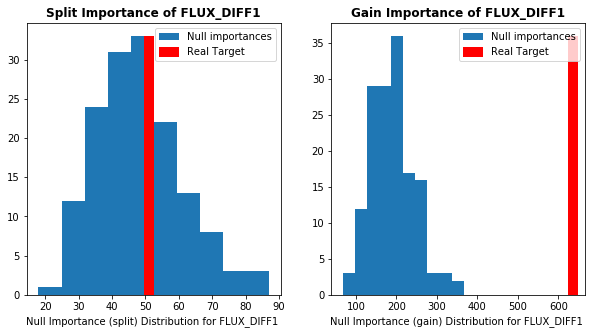

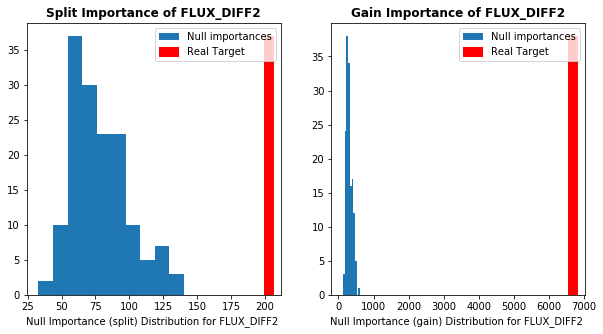

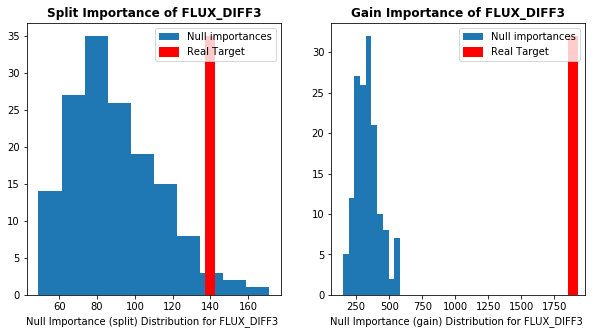

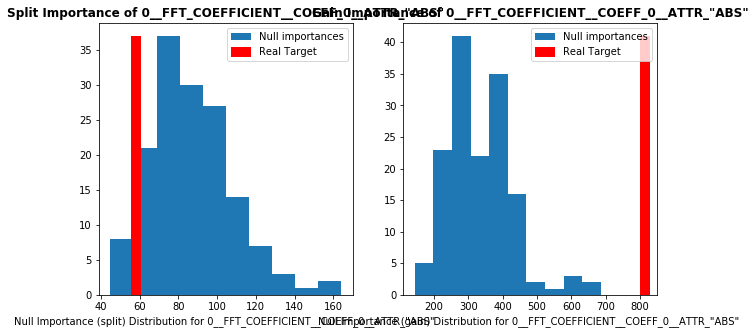

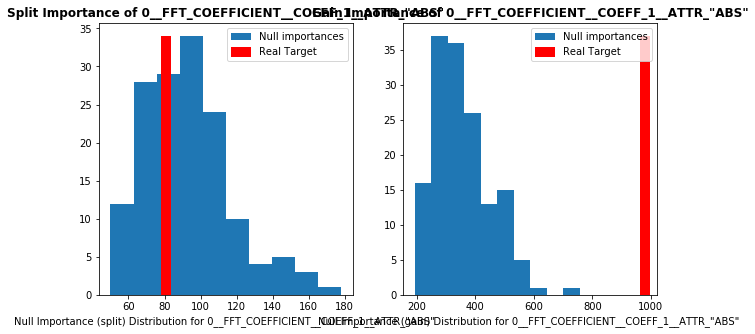

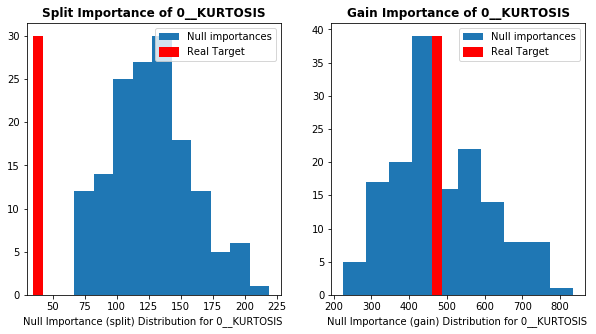

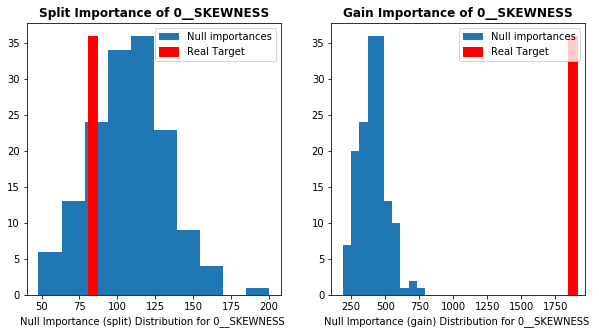

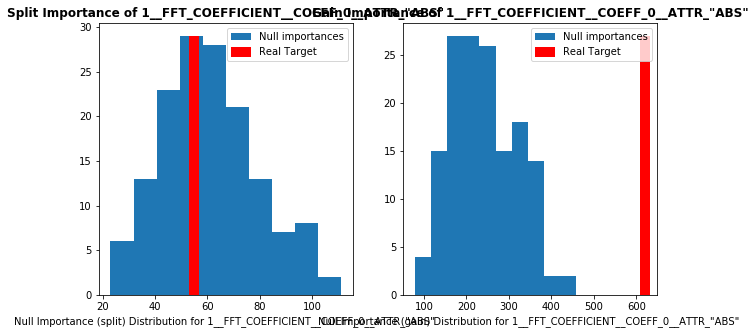

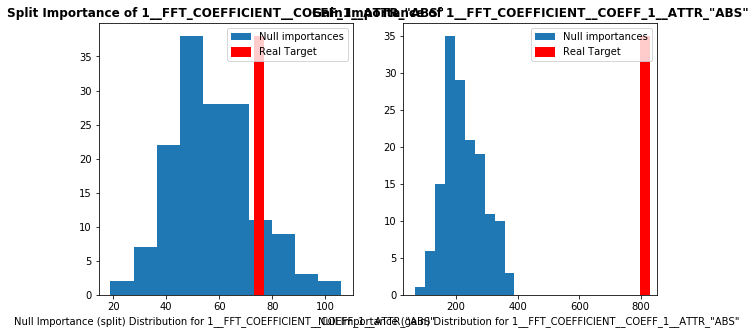

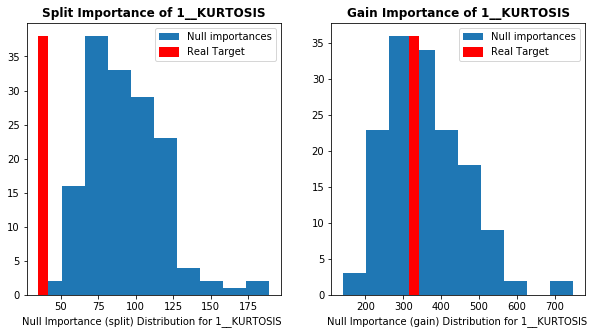

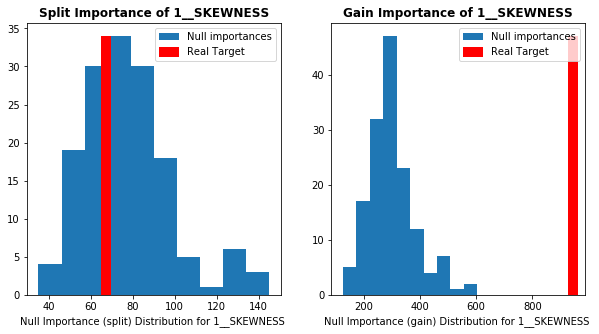

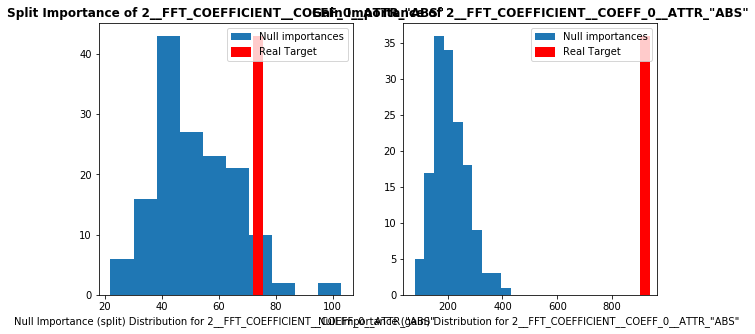

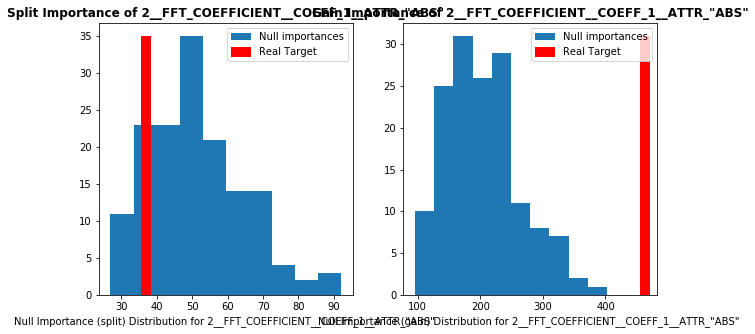

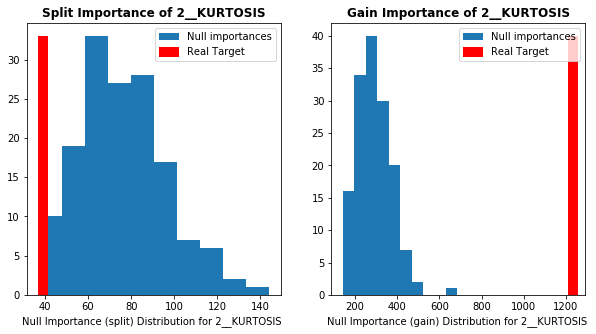

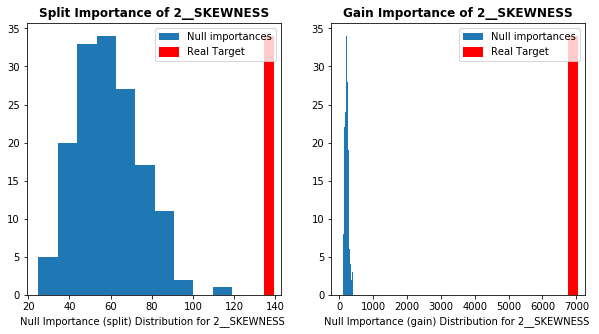

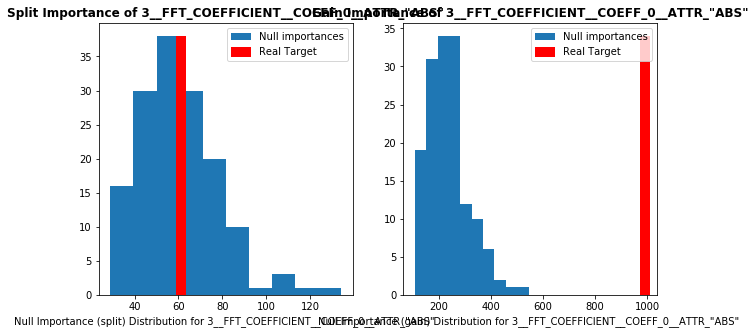

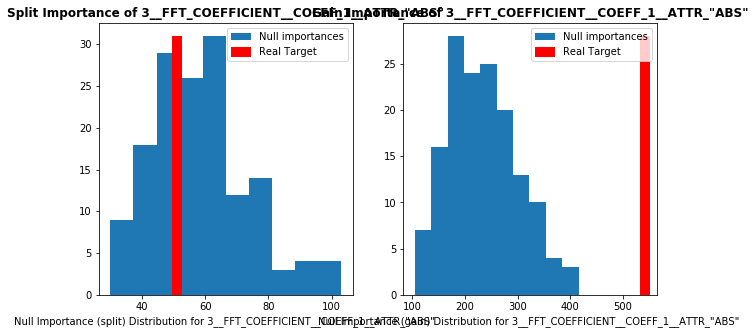

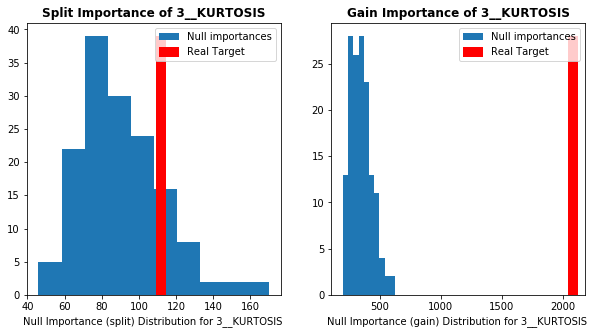

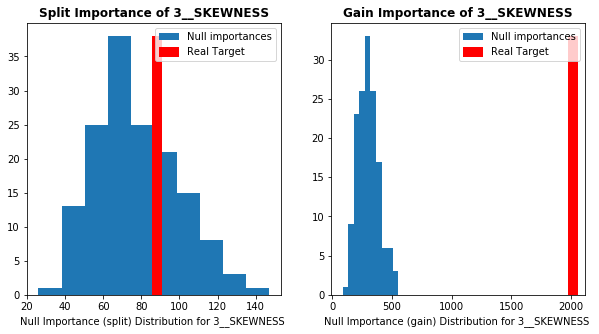

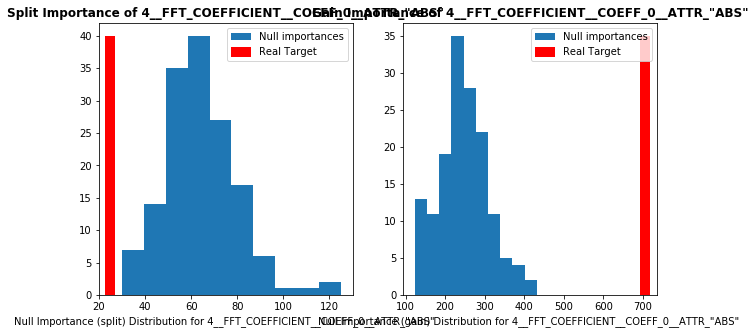

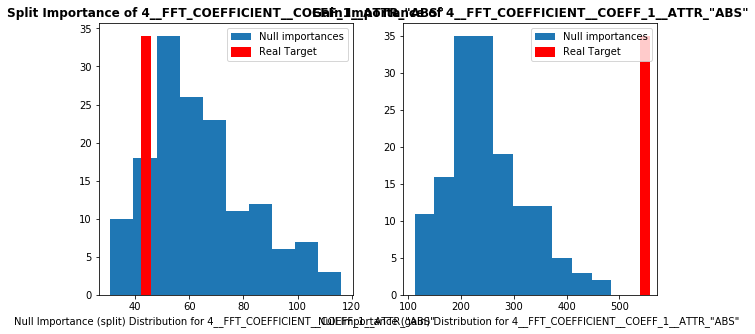

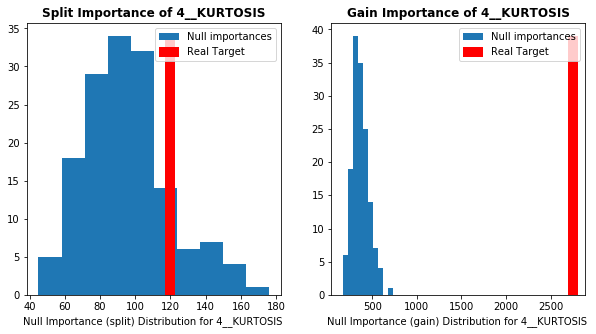

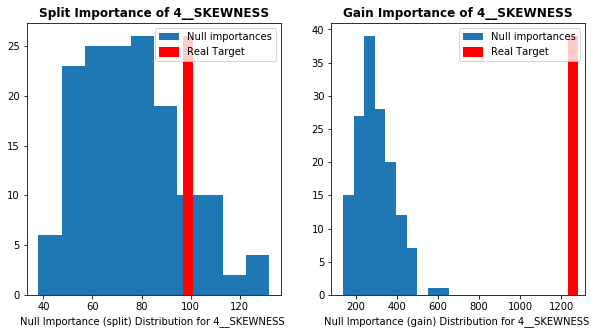

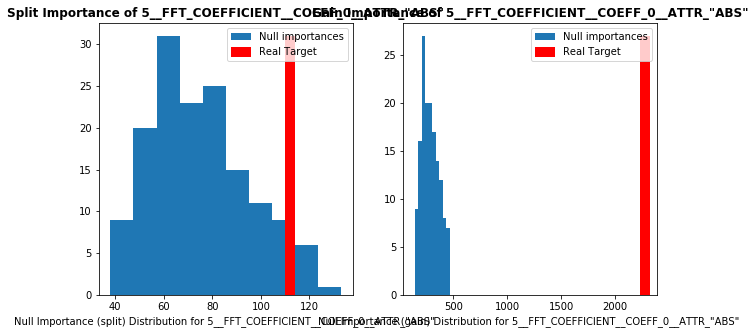

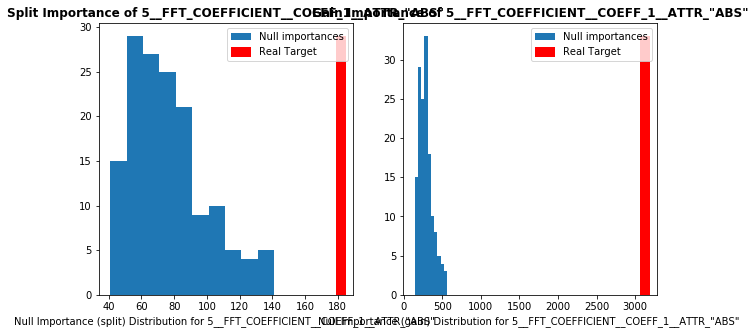

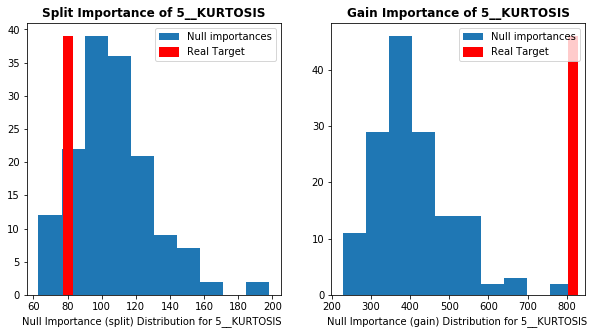

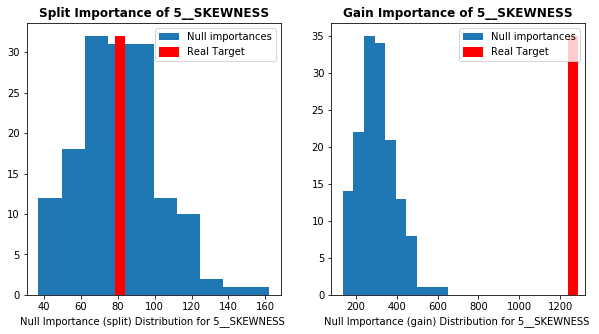

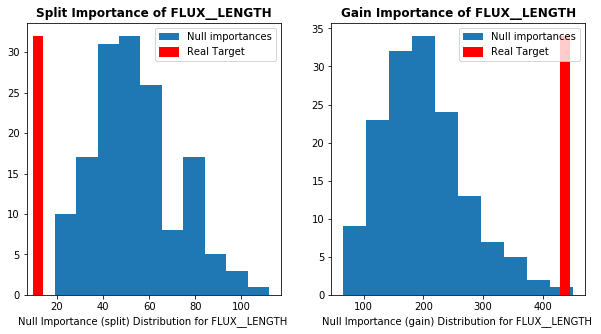

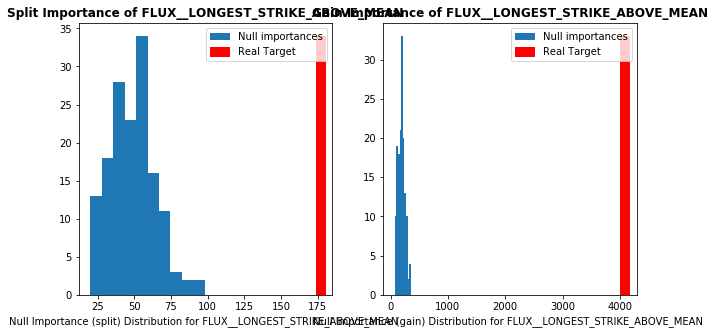

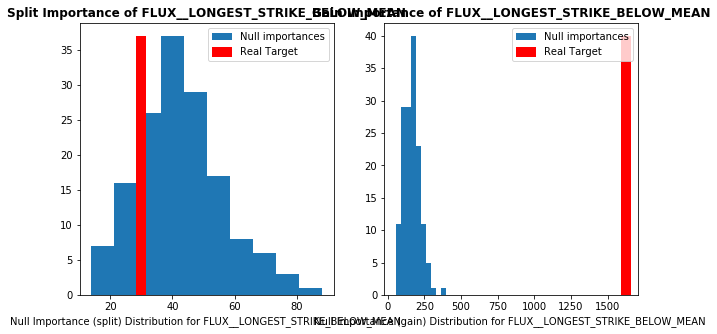

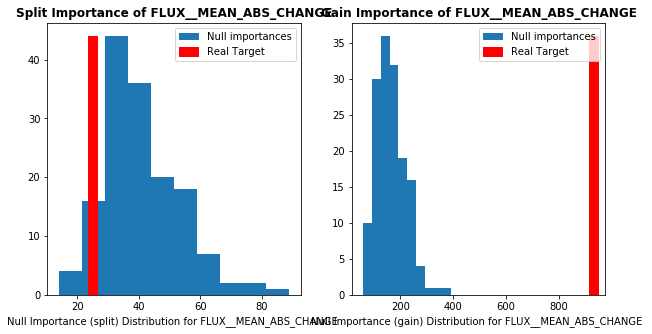

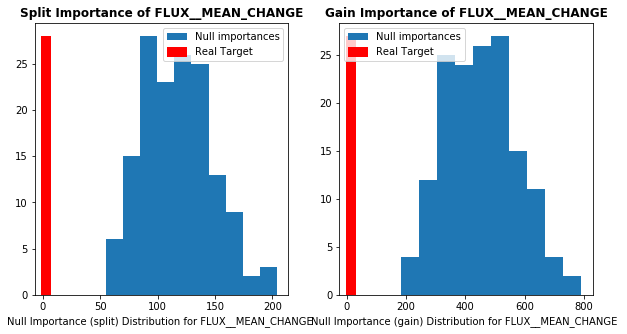

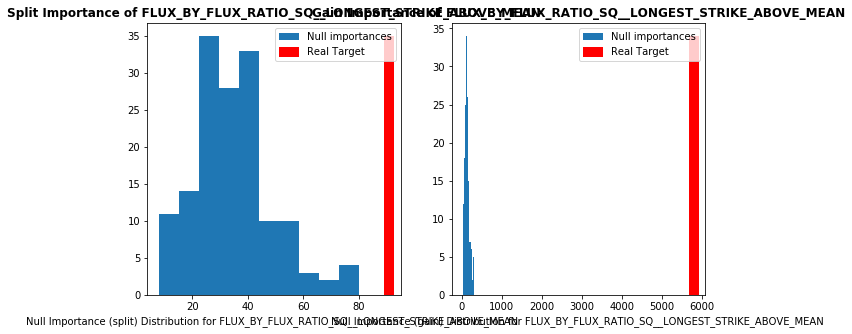

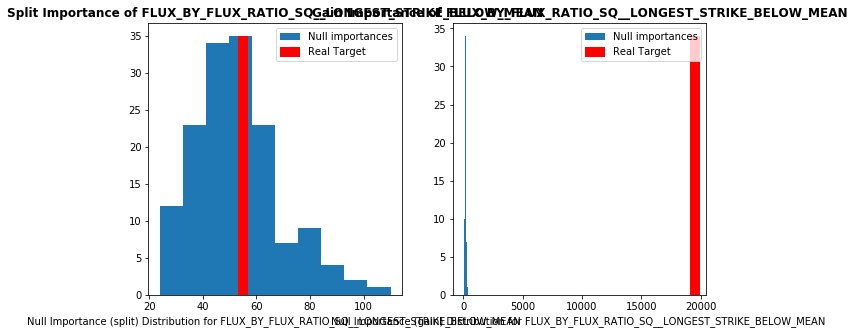

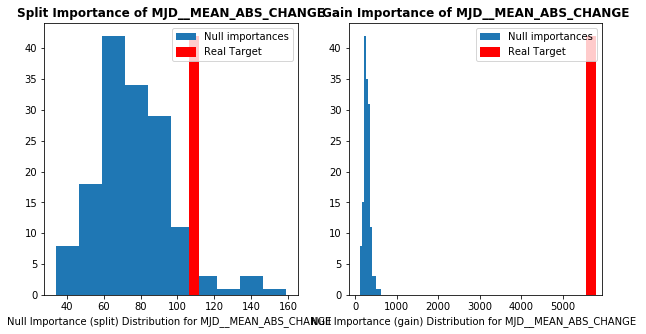

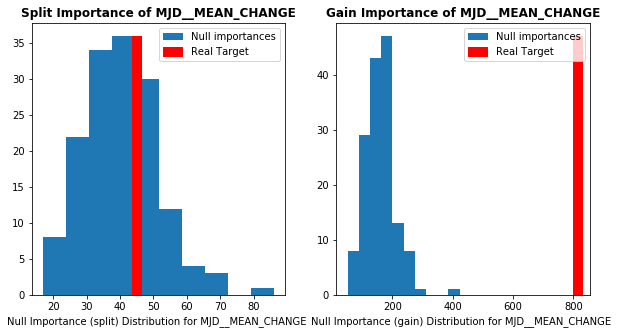

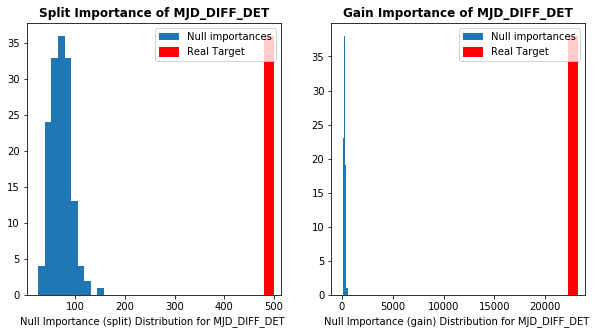

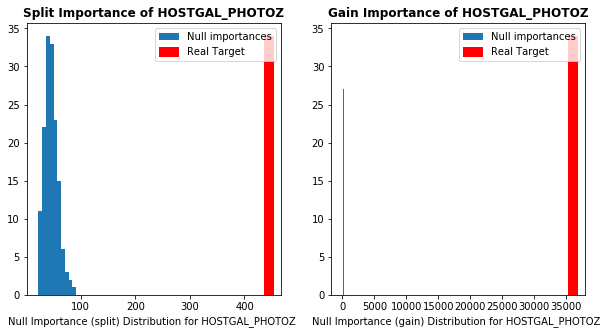

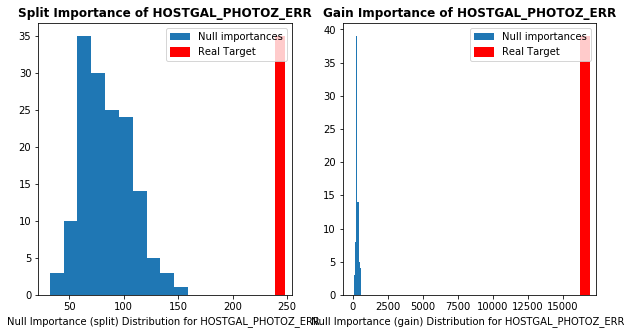

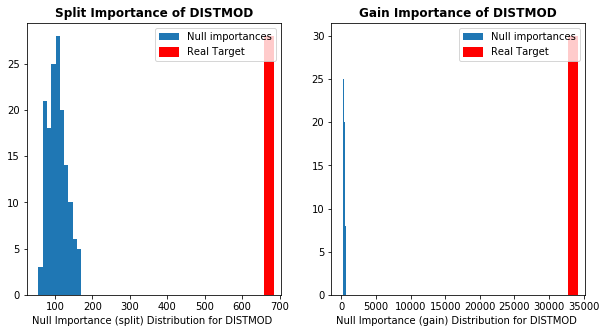

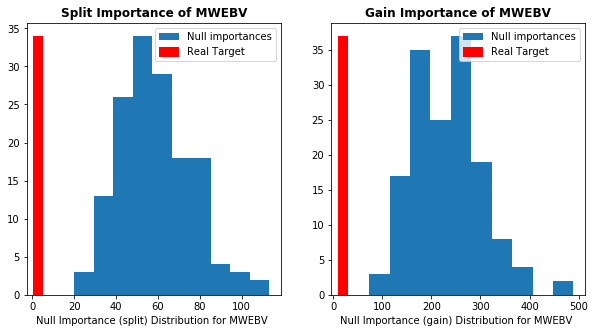

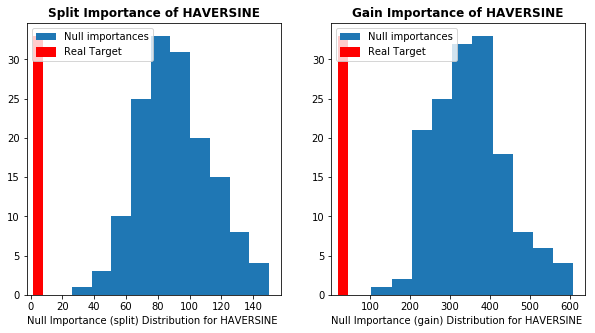

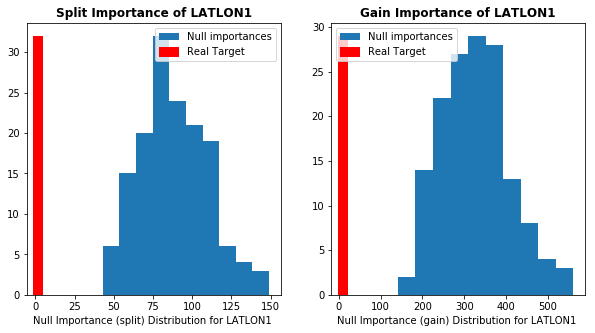

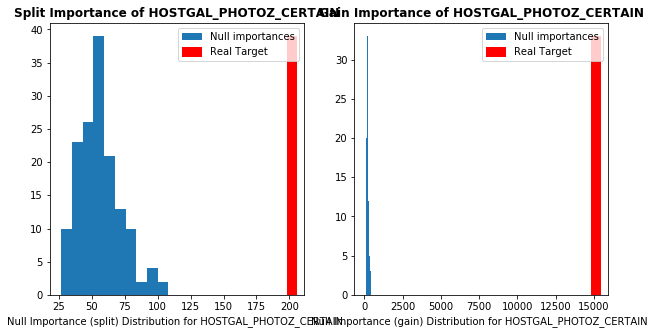

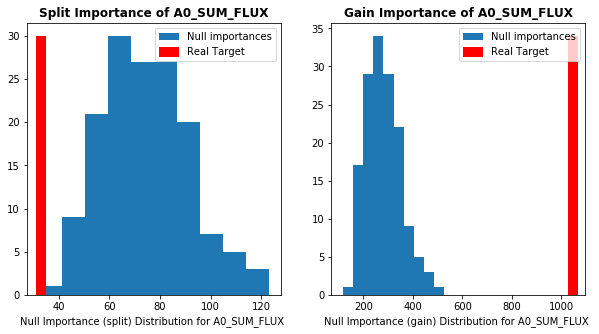

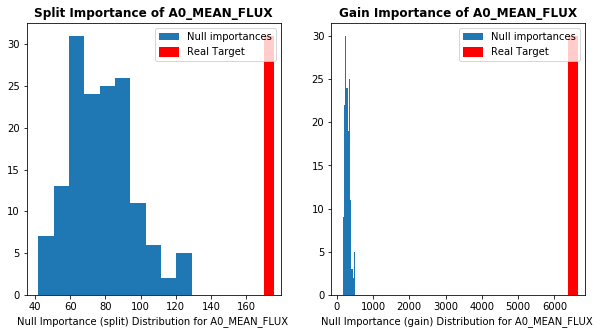

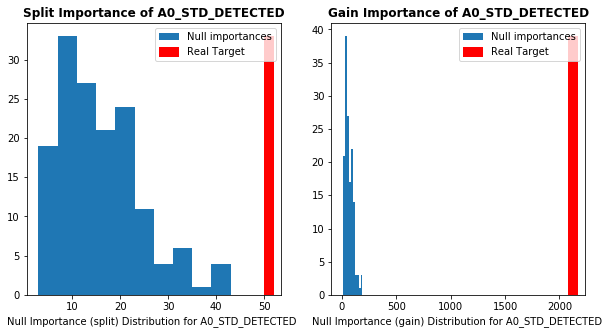

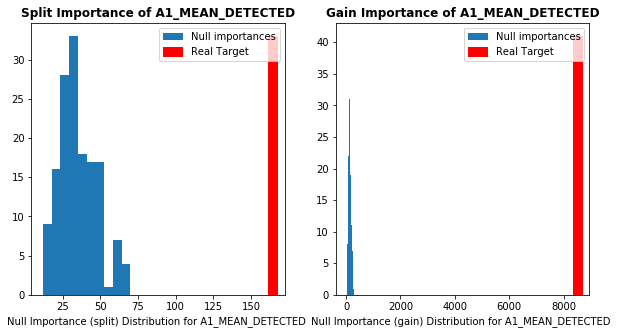

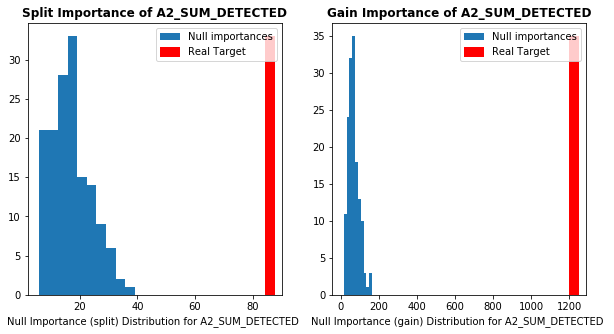

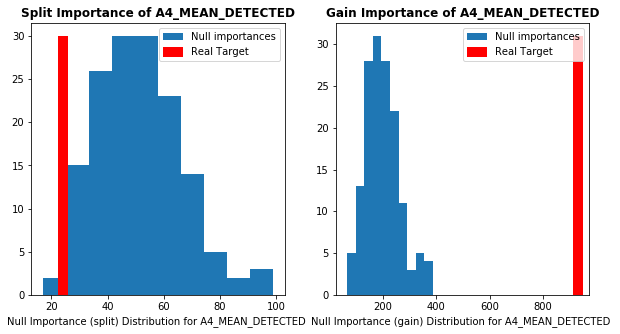

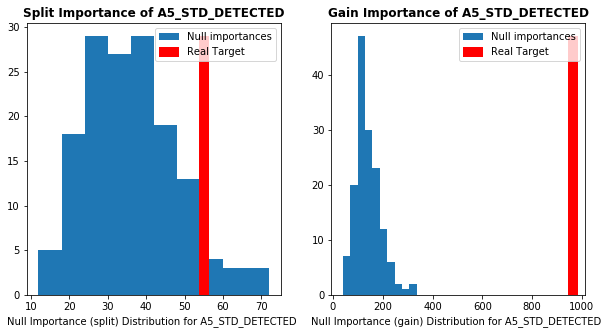

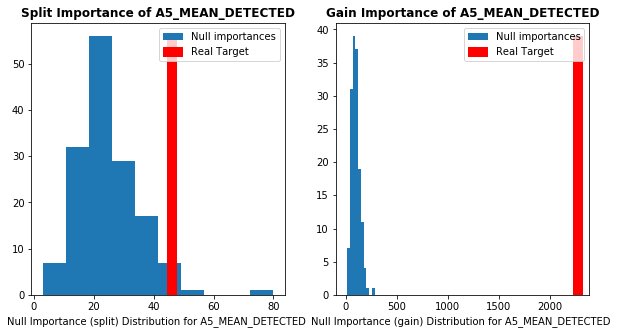

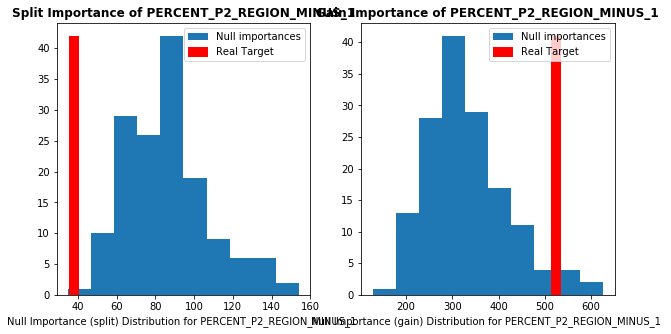

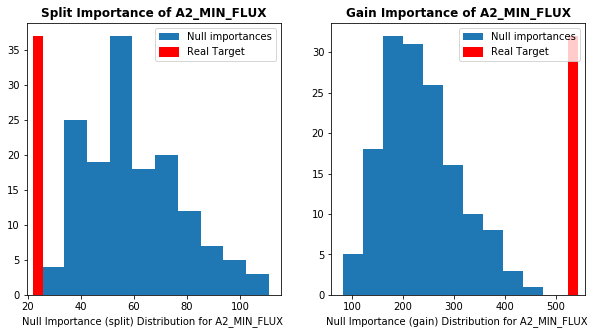

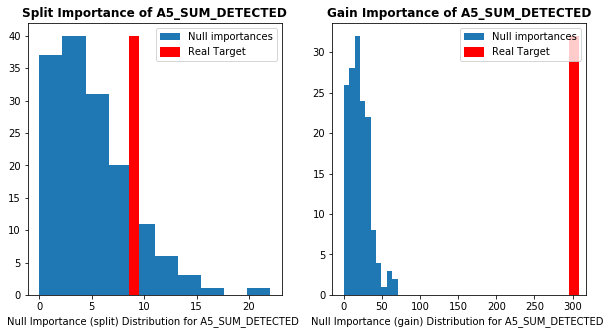

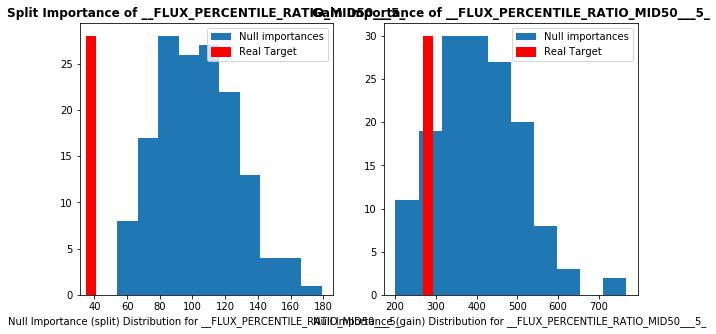

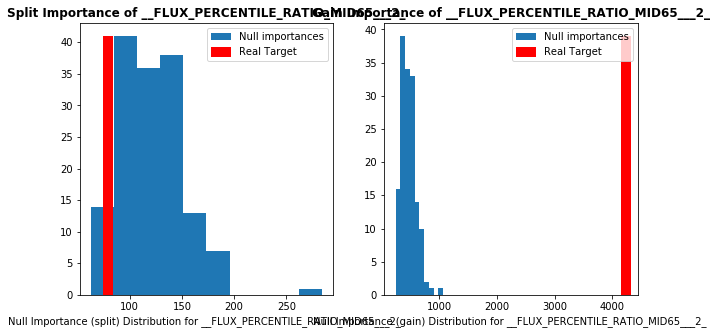

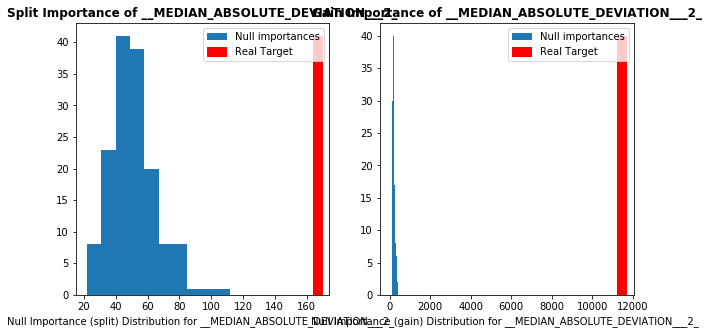

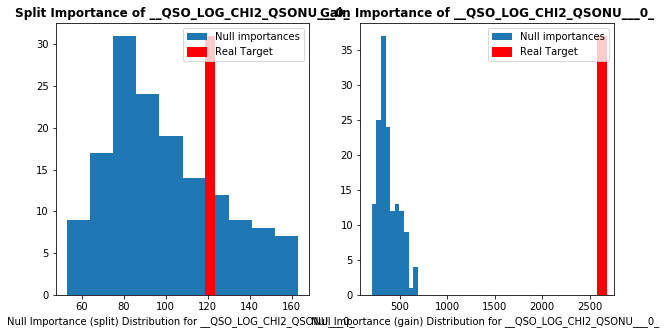

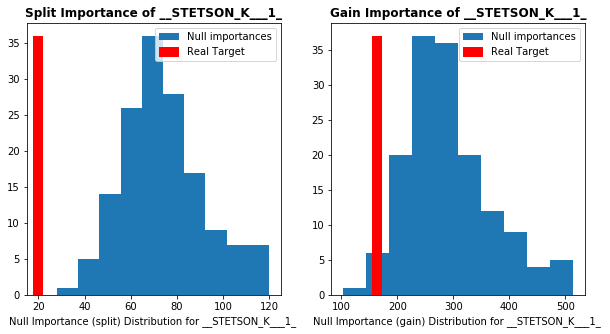

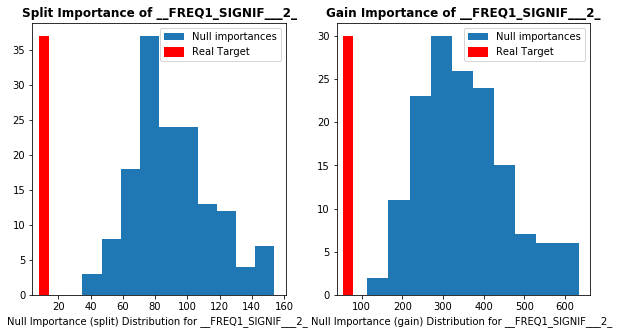

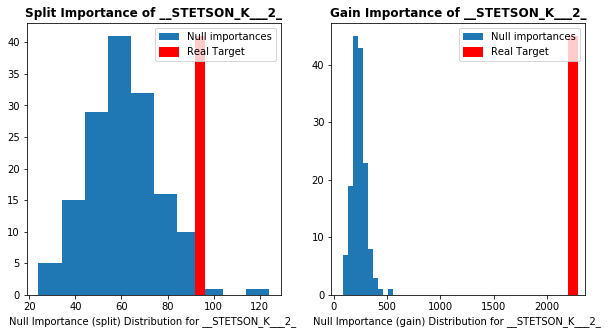

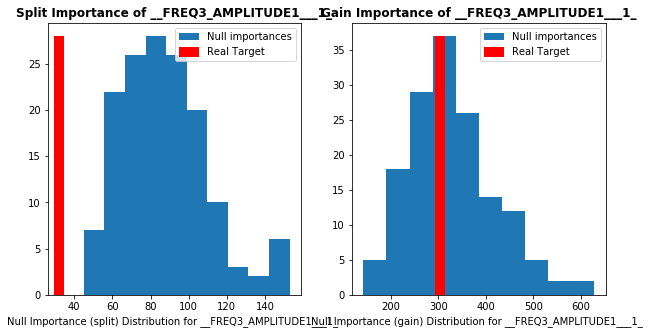

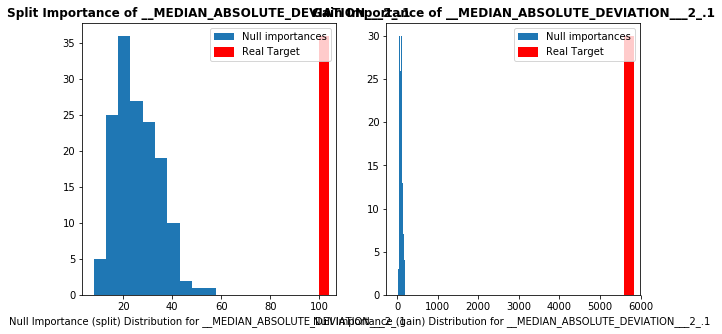

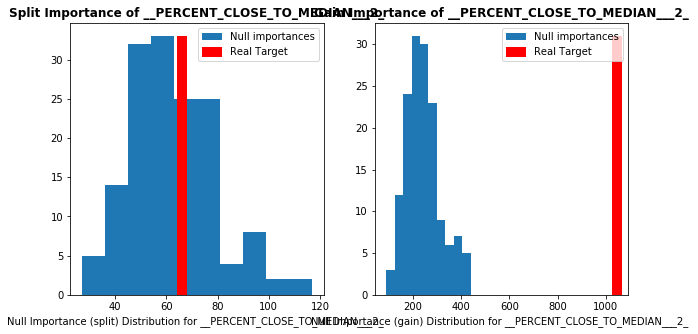

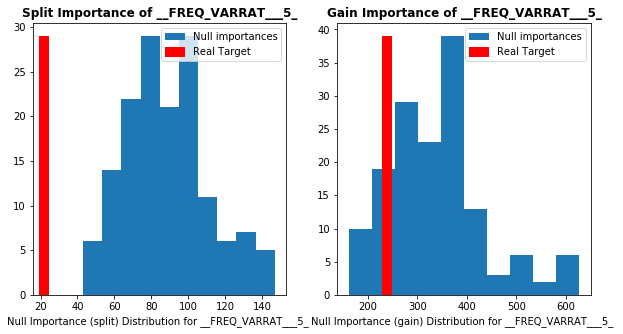

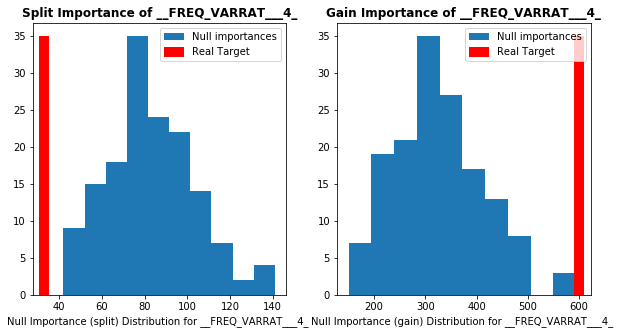

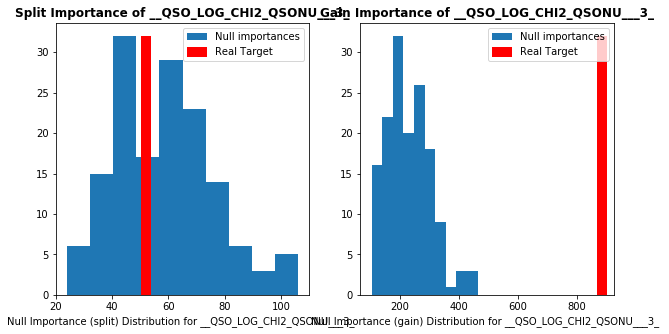

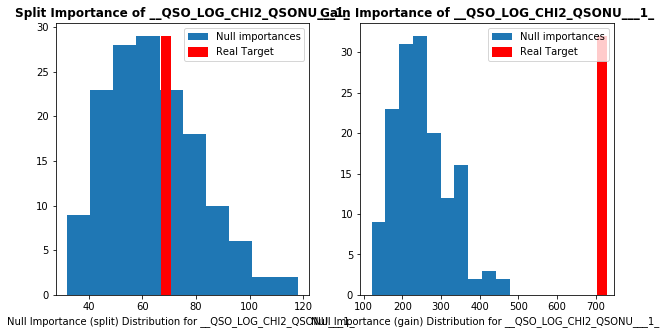

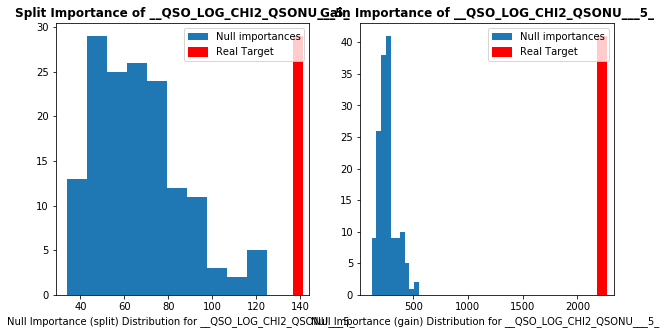

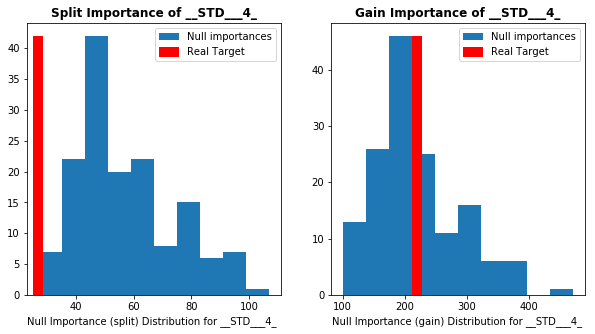

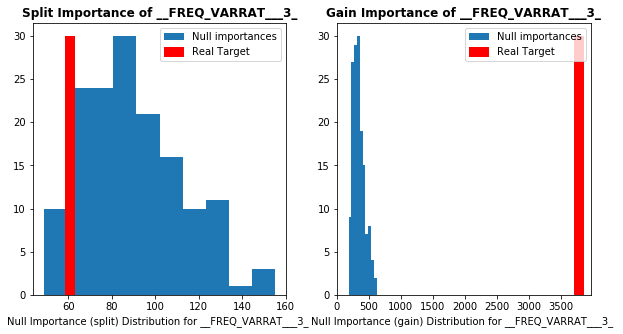

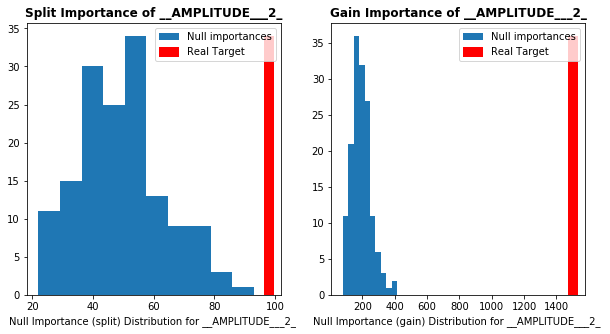

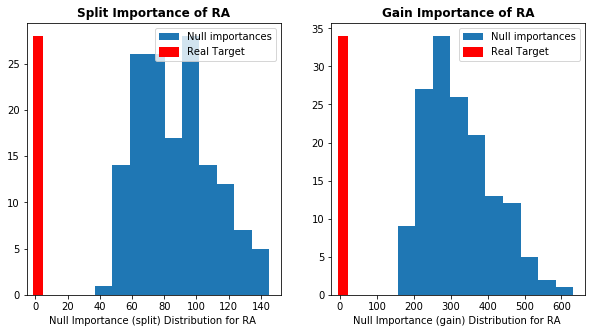

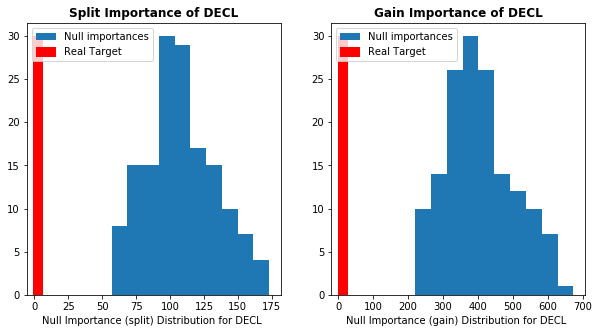

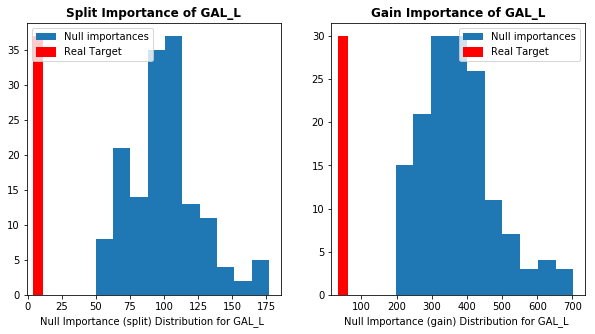

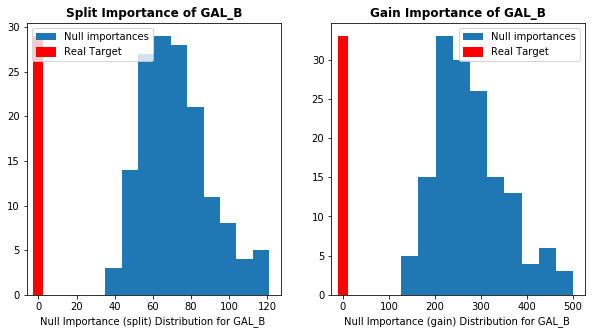

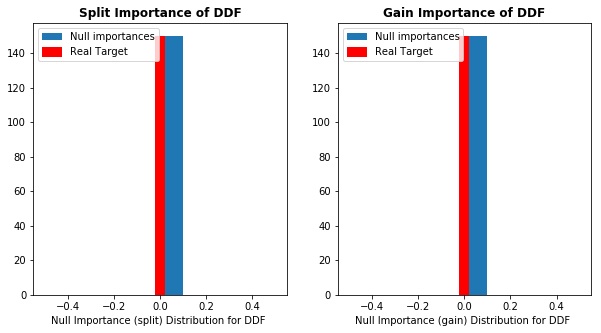

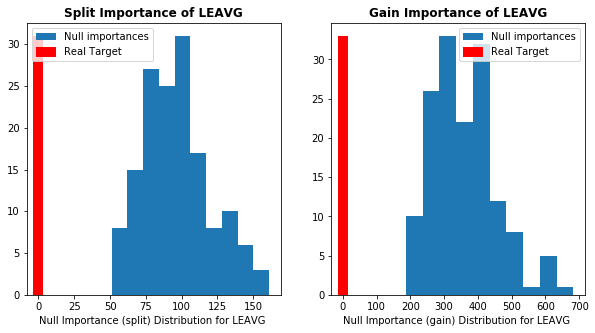

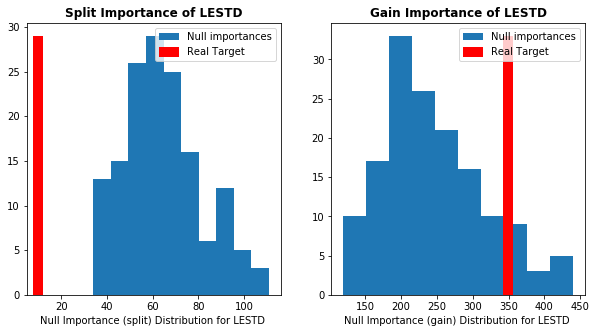

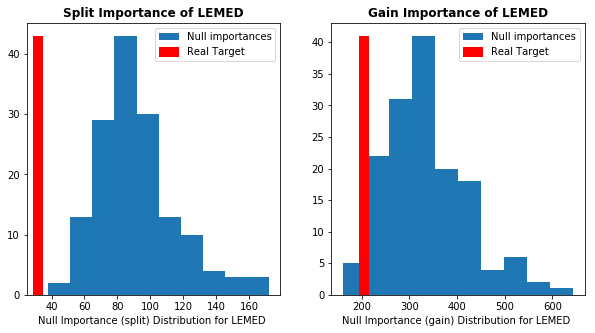

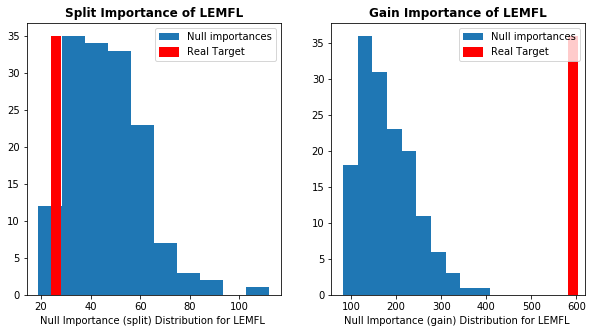

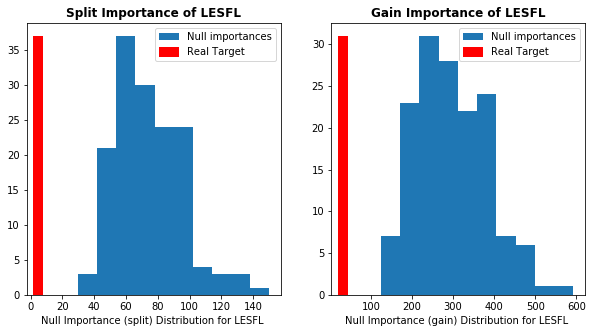

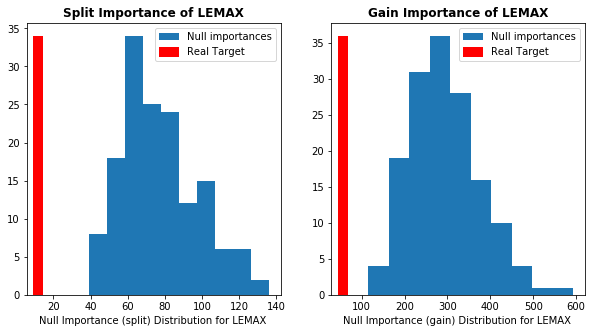

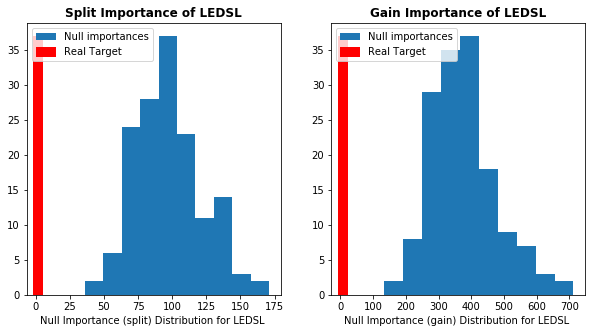

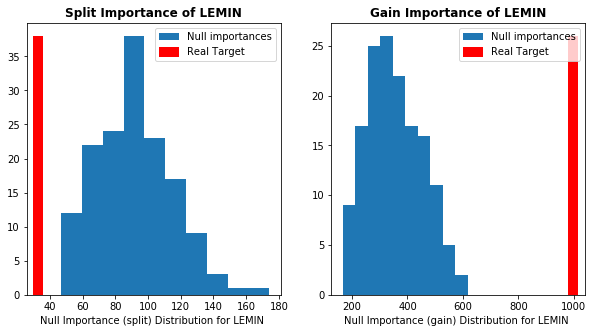

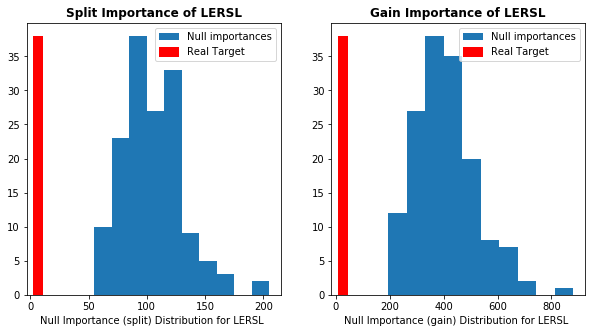

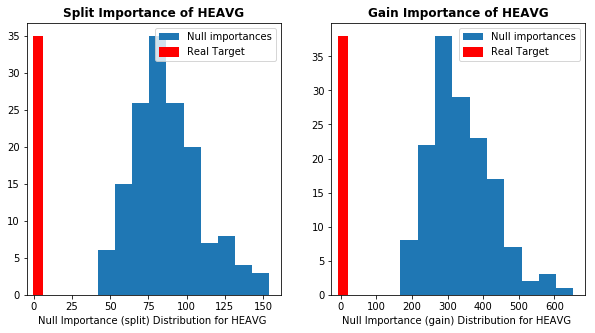

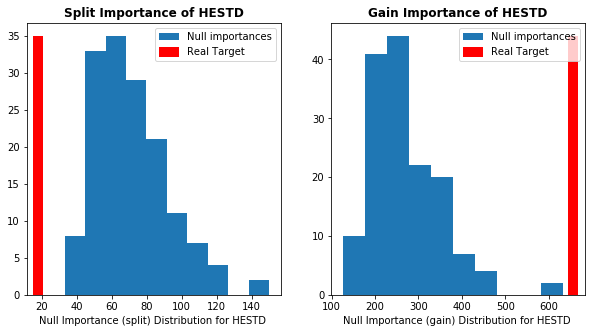

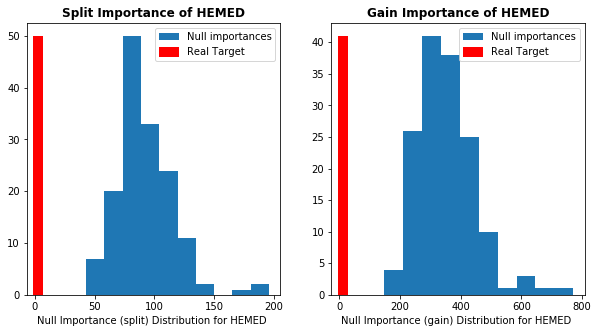

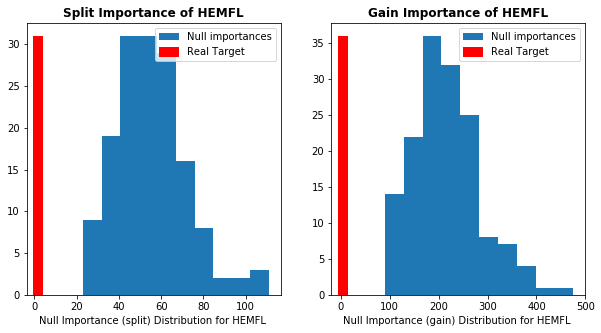

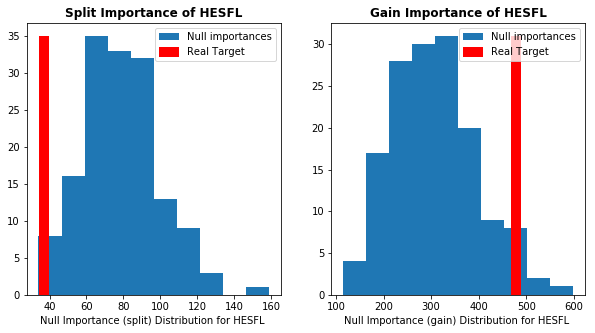

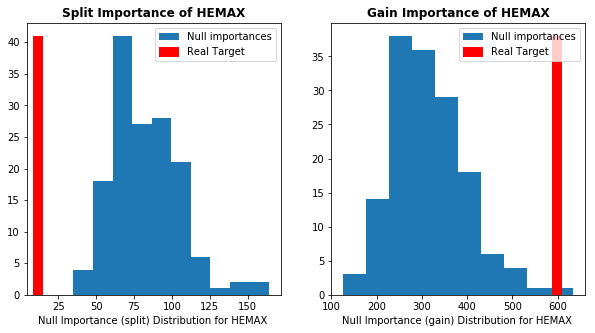

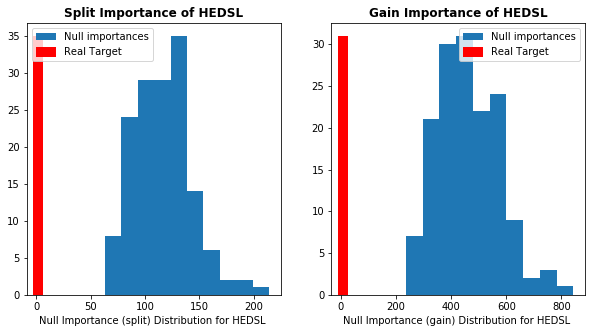

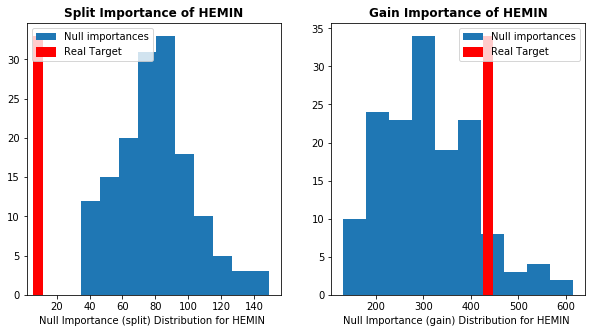

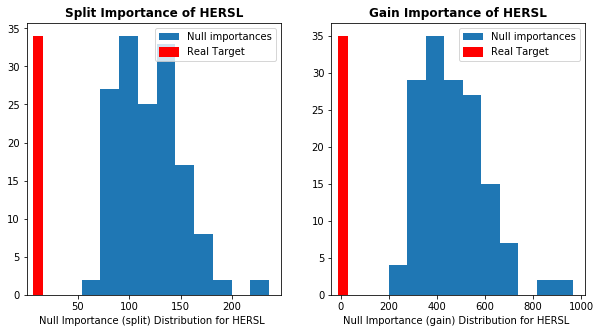

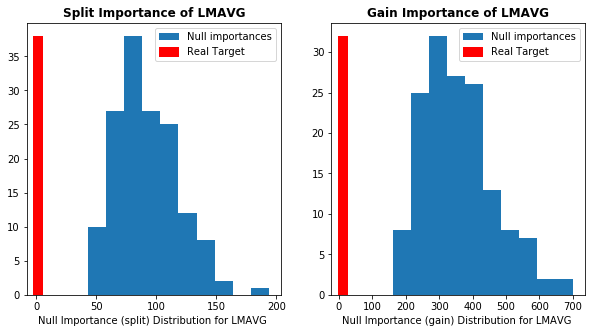

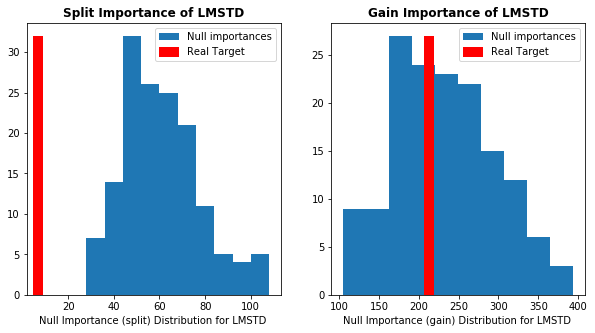

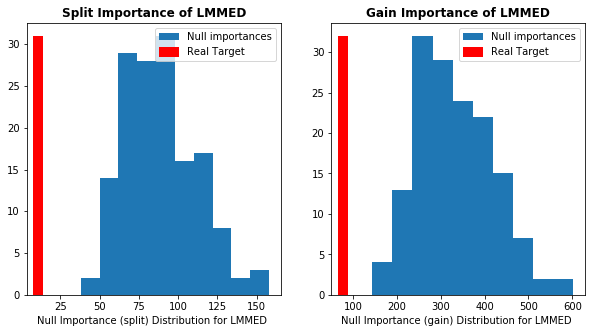

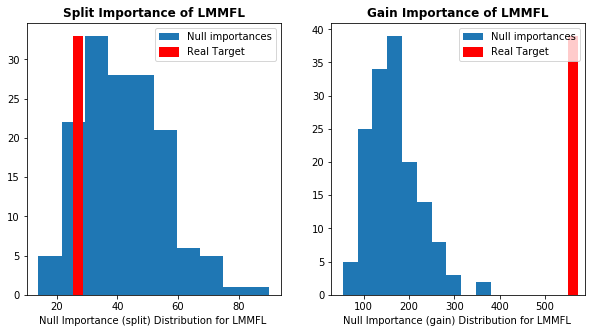

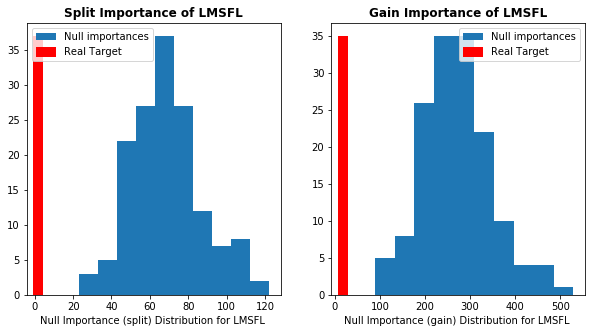

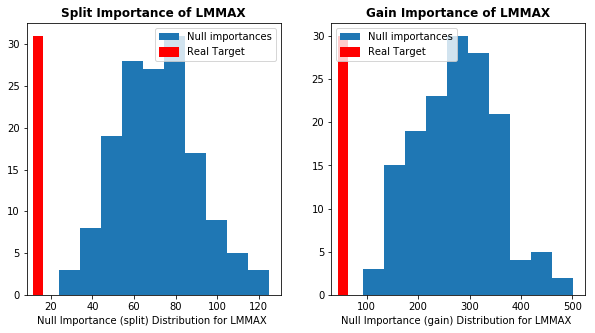

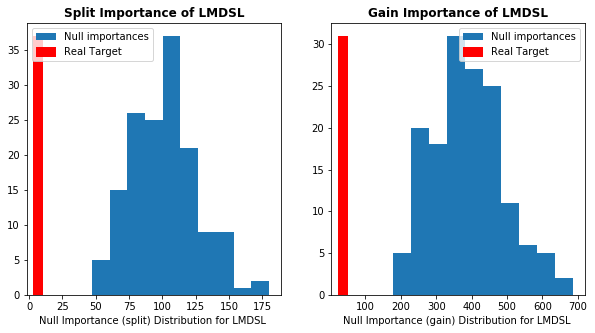

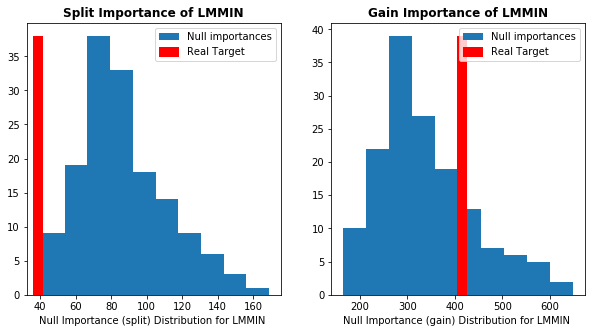

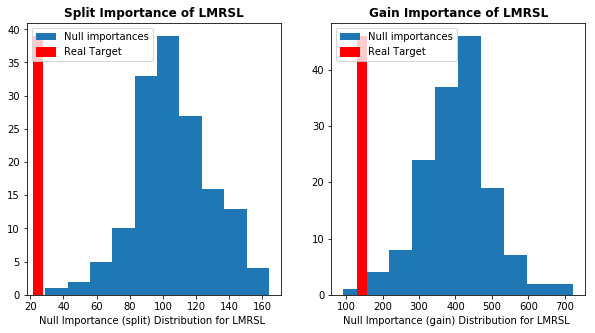

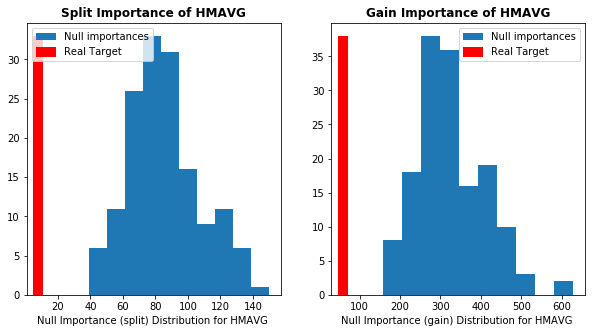

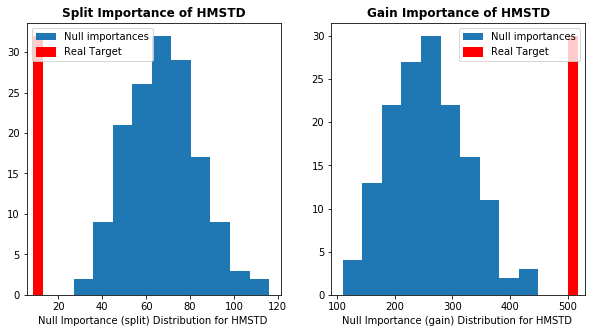

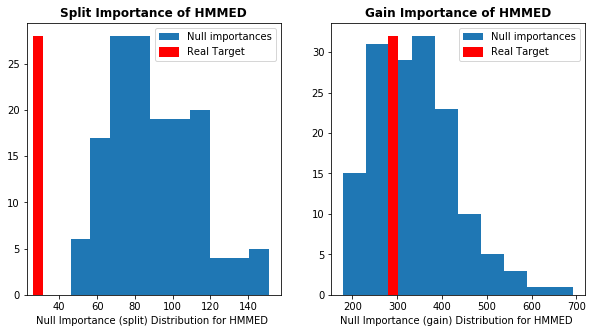

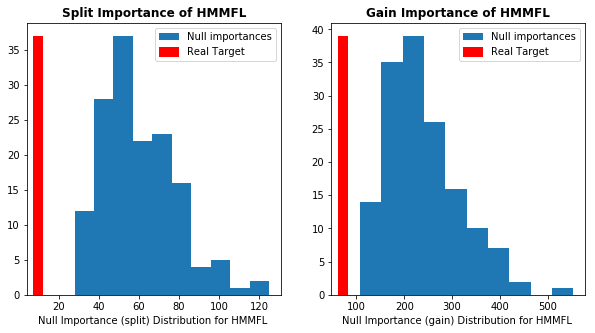

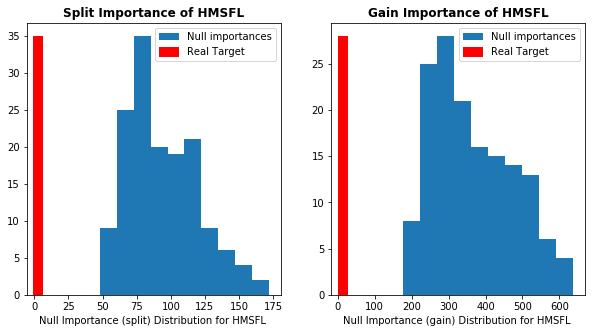

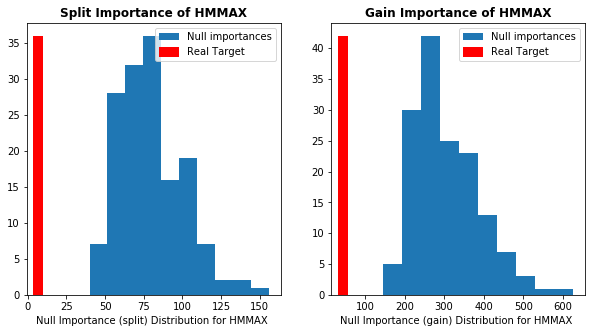

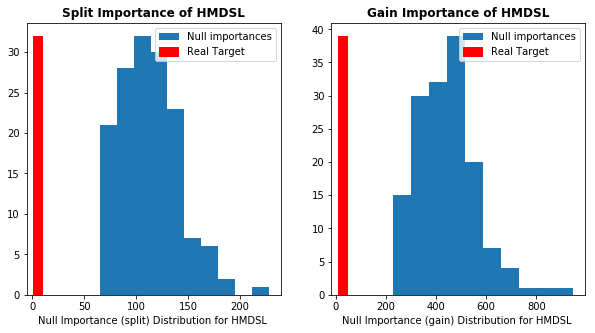

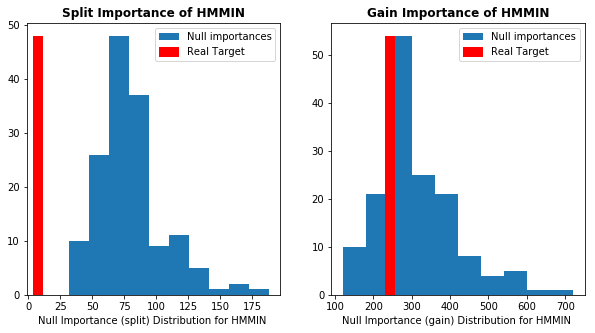

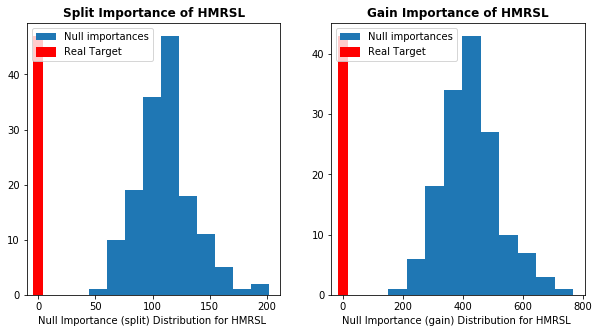

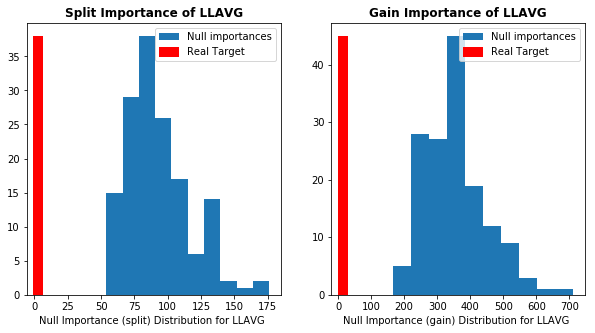

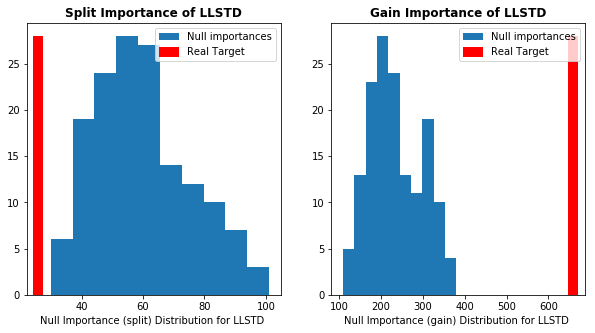

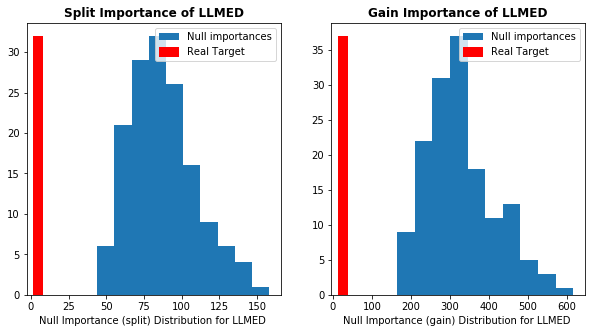

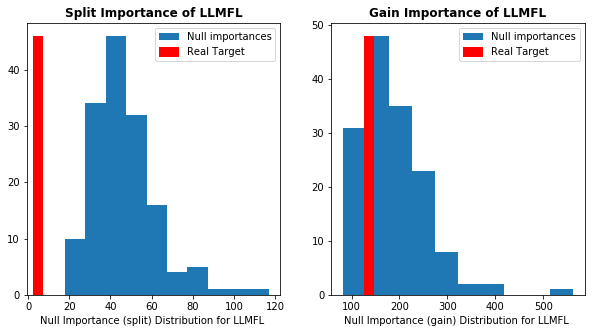

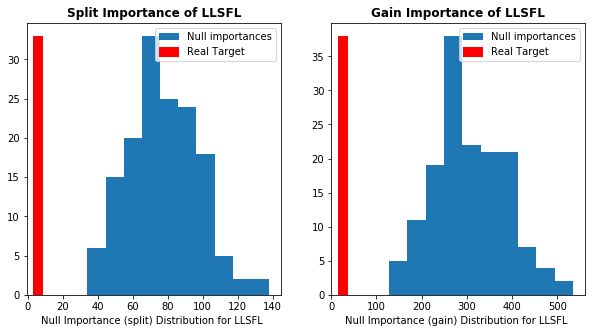

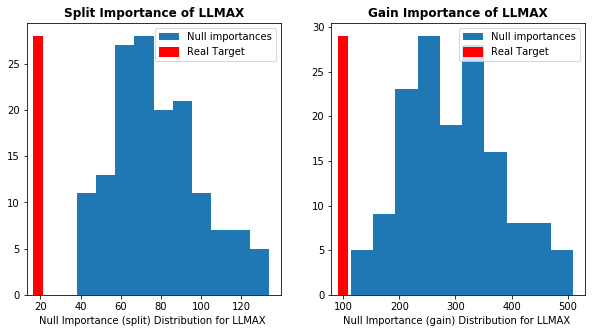

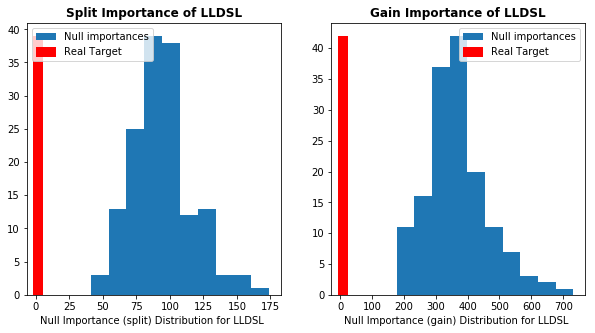

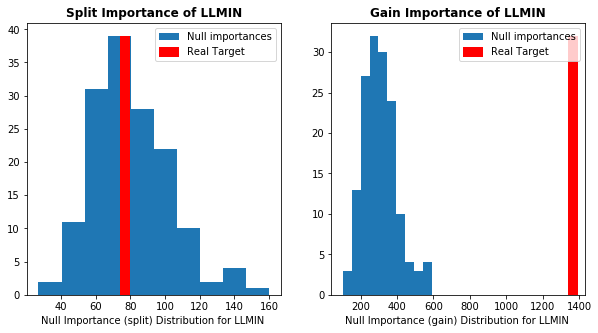

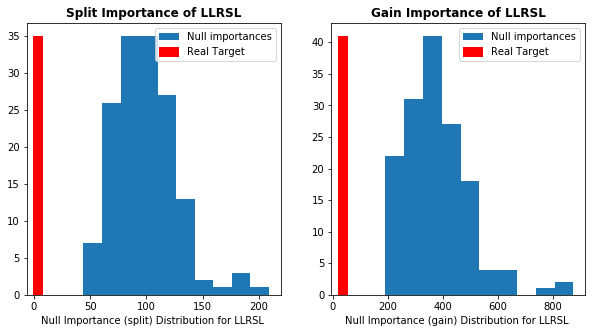

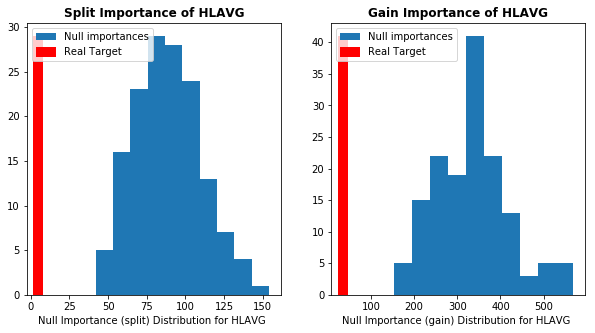

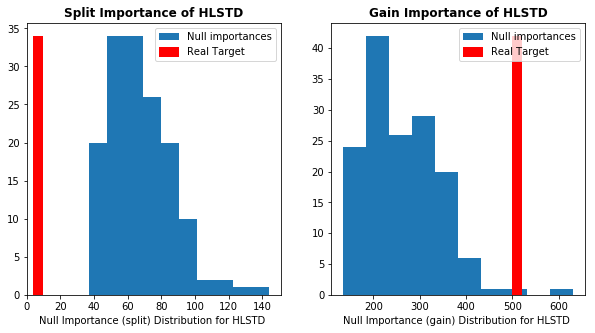

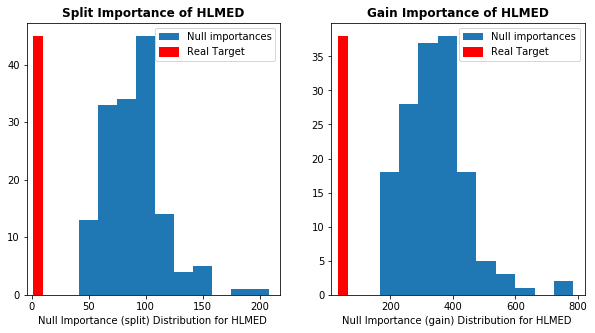

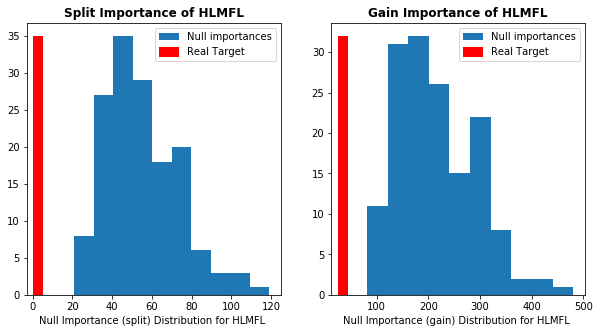

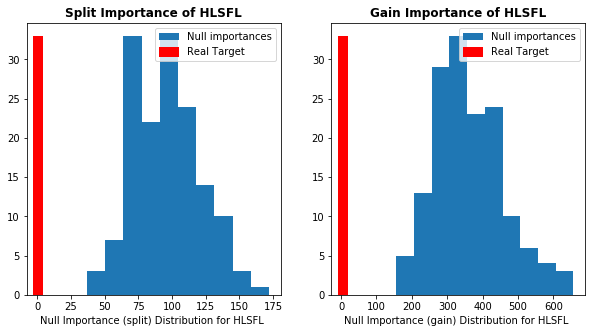

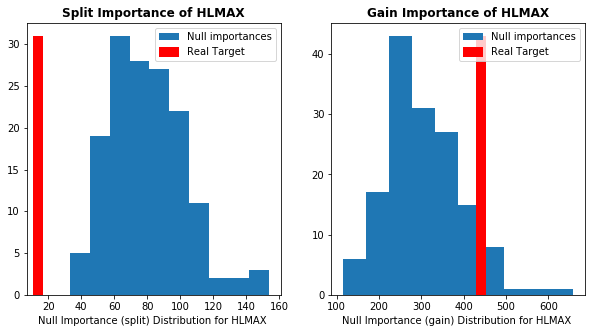

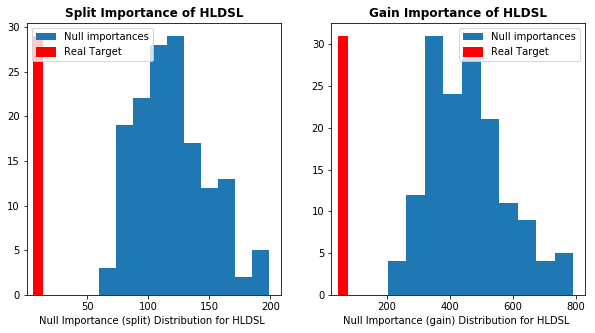

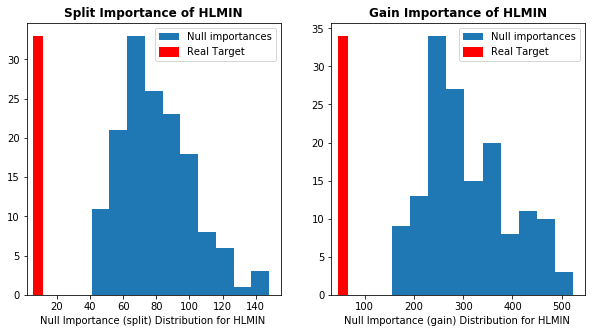

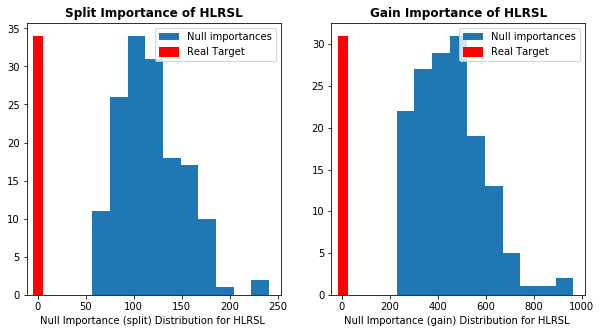

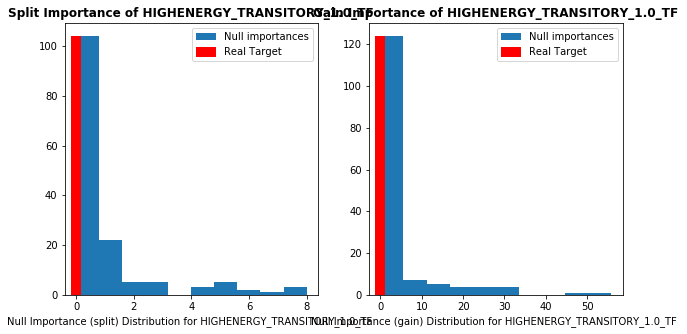

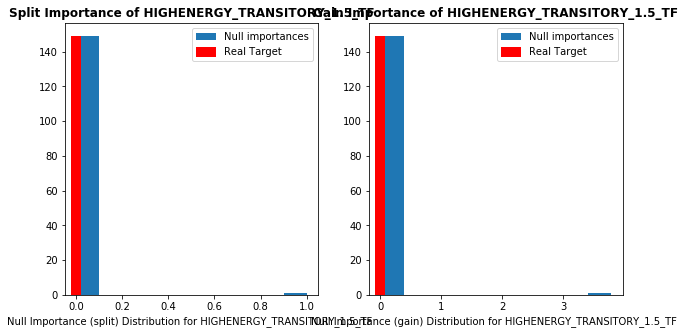

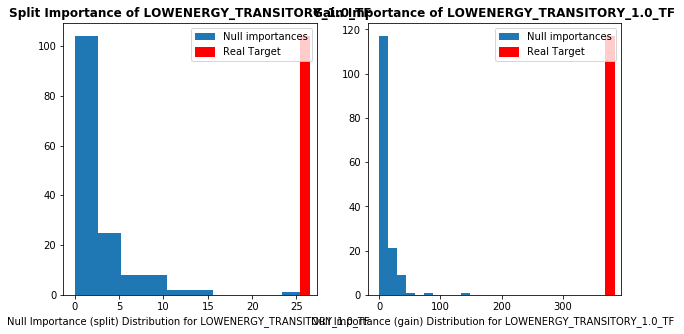

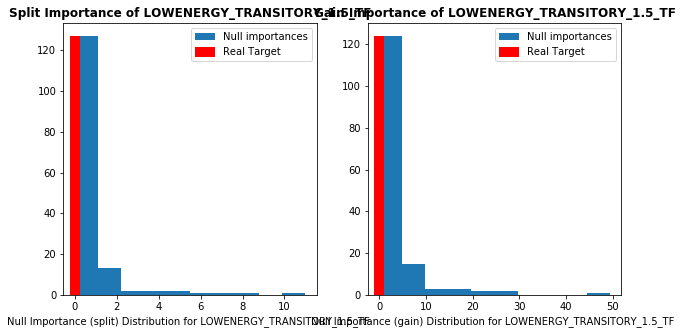

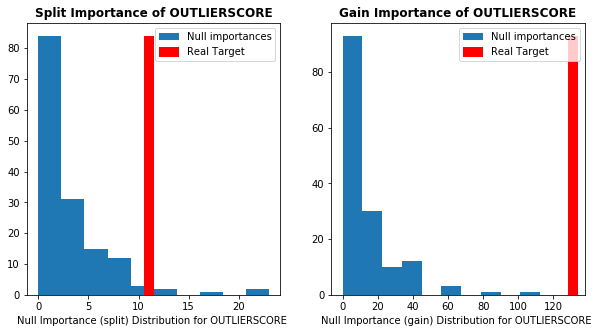

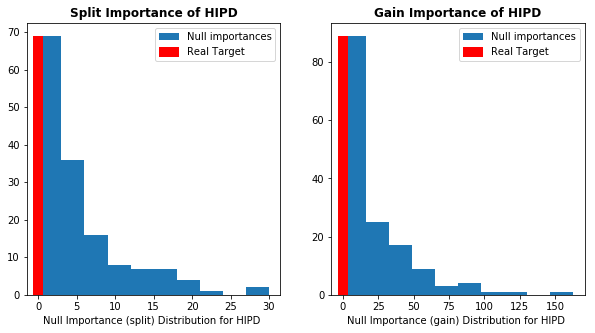

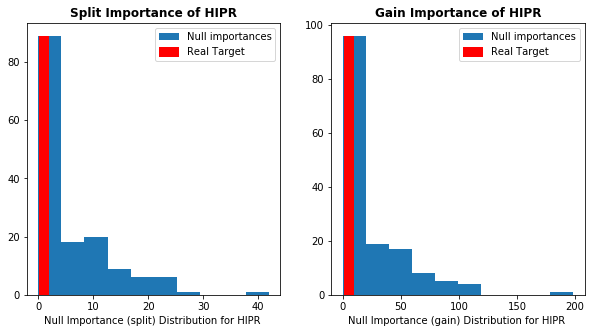

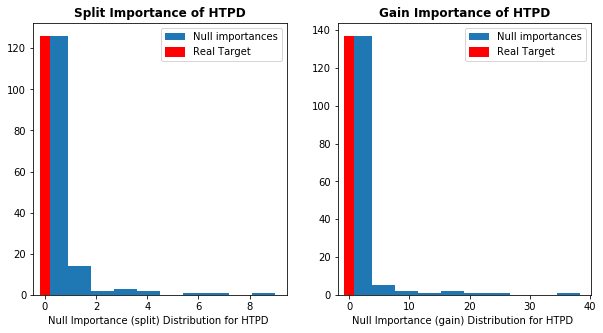

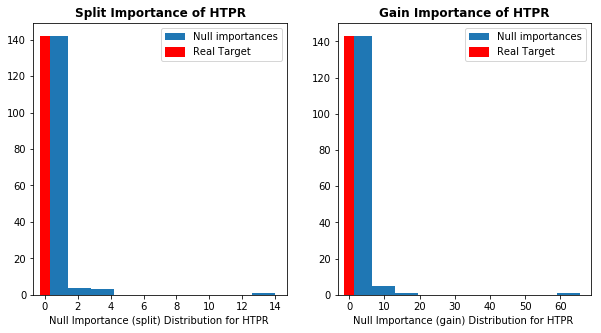

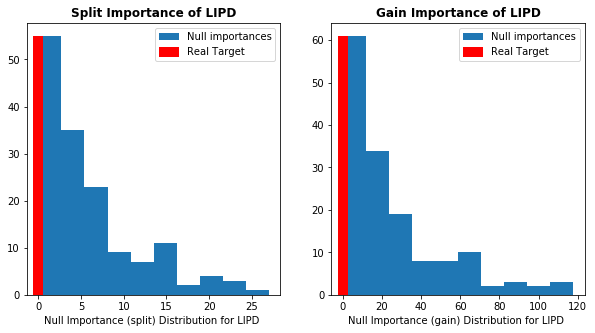

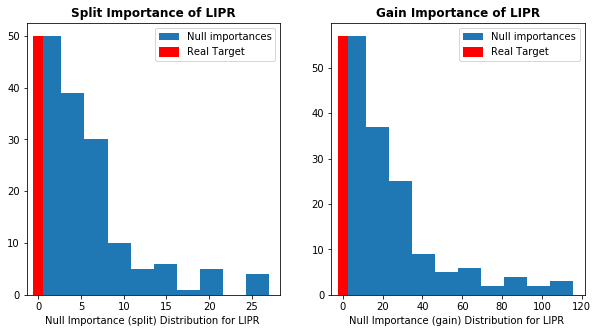

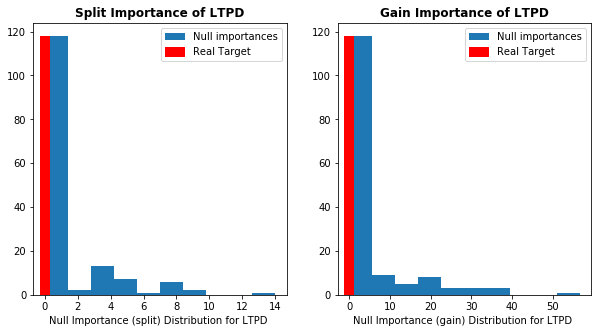

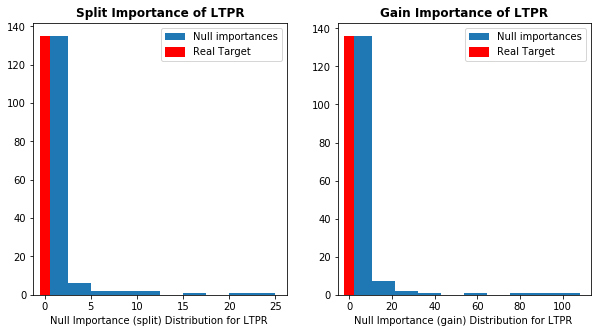

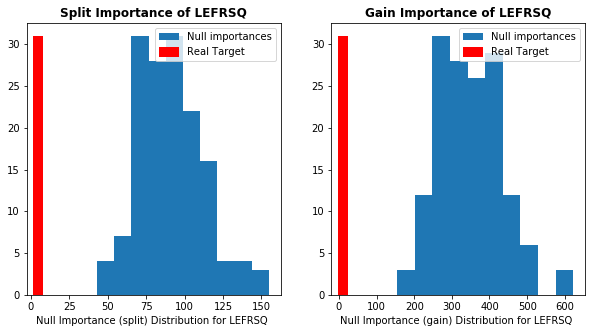

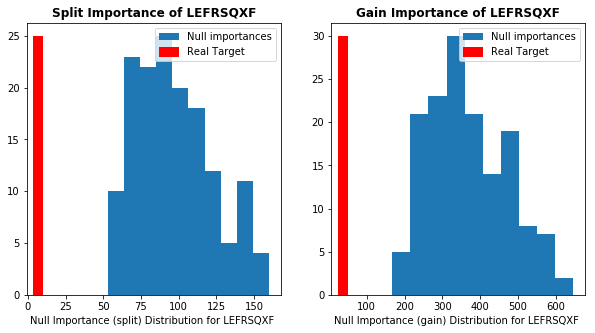

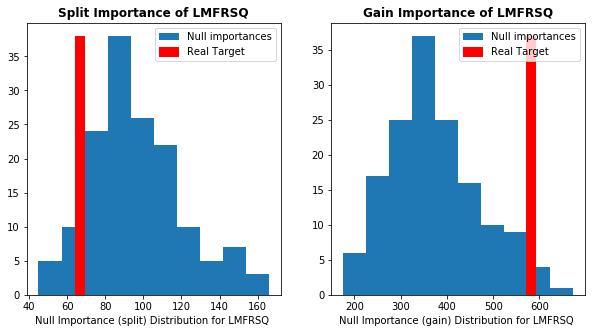

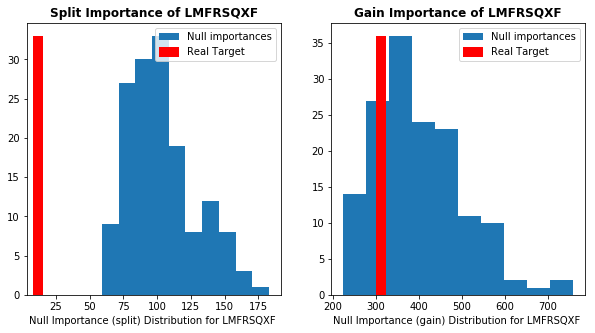

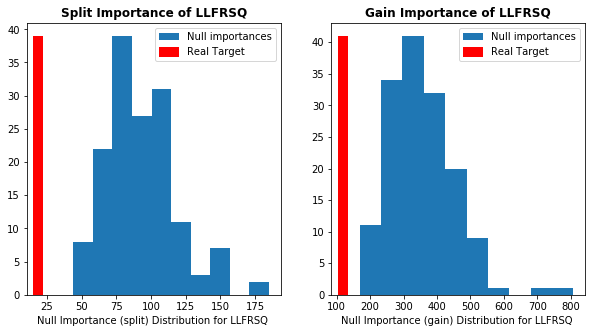

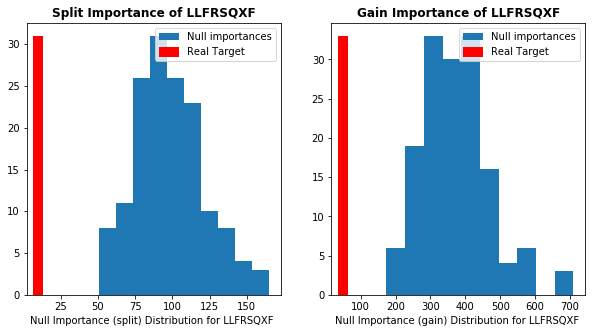

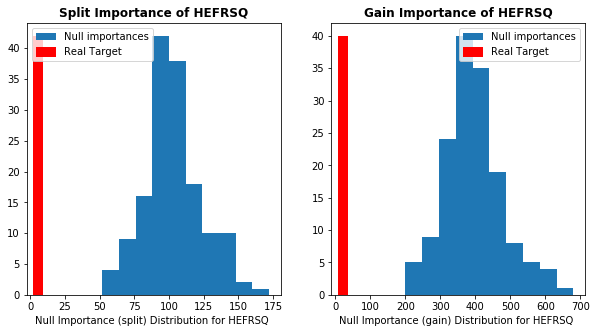

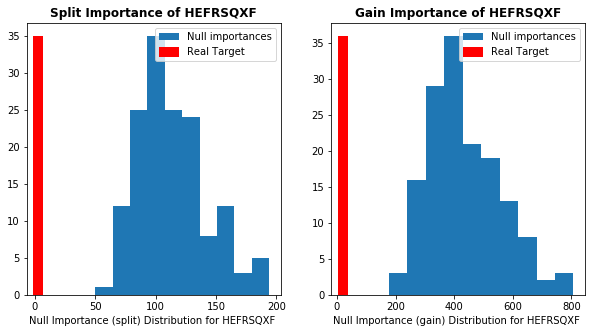

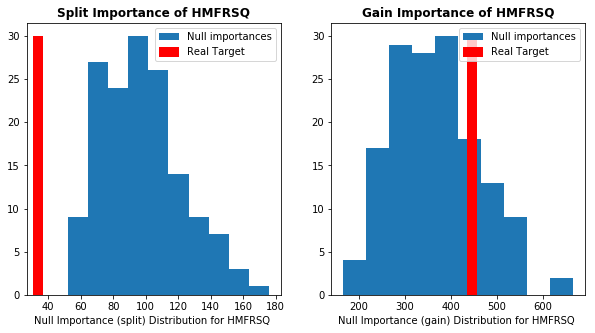

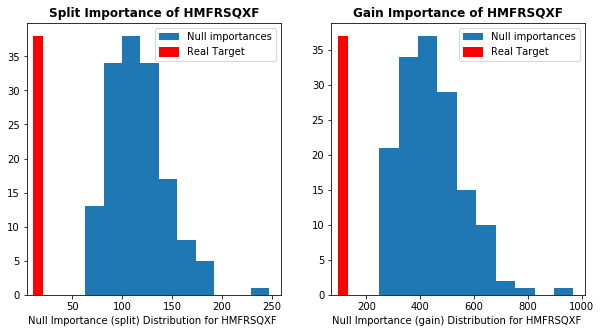

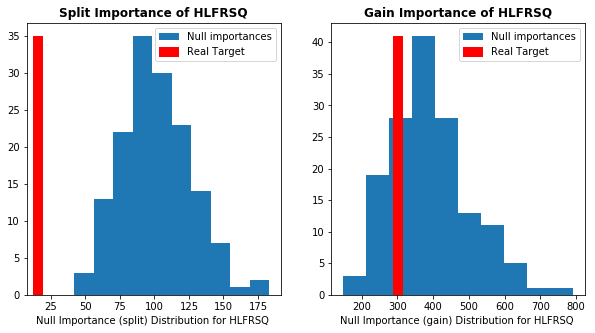

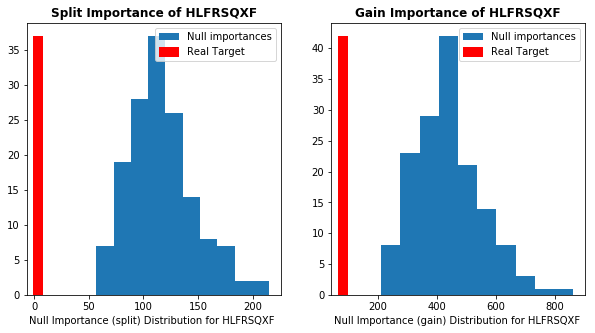

In [33]:
for i in [x for x in list(temp.columns.values) if x not in ['target', 'object_id'] ]:
    display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=i)

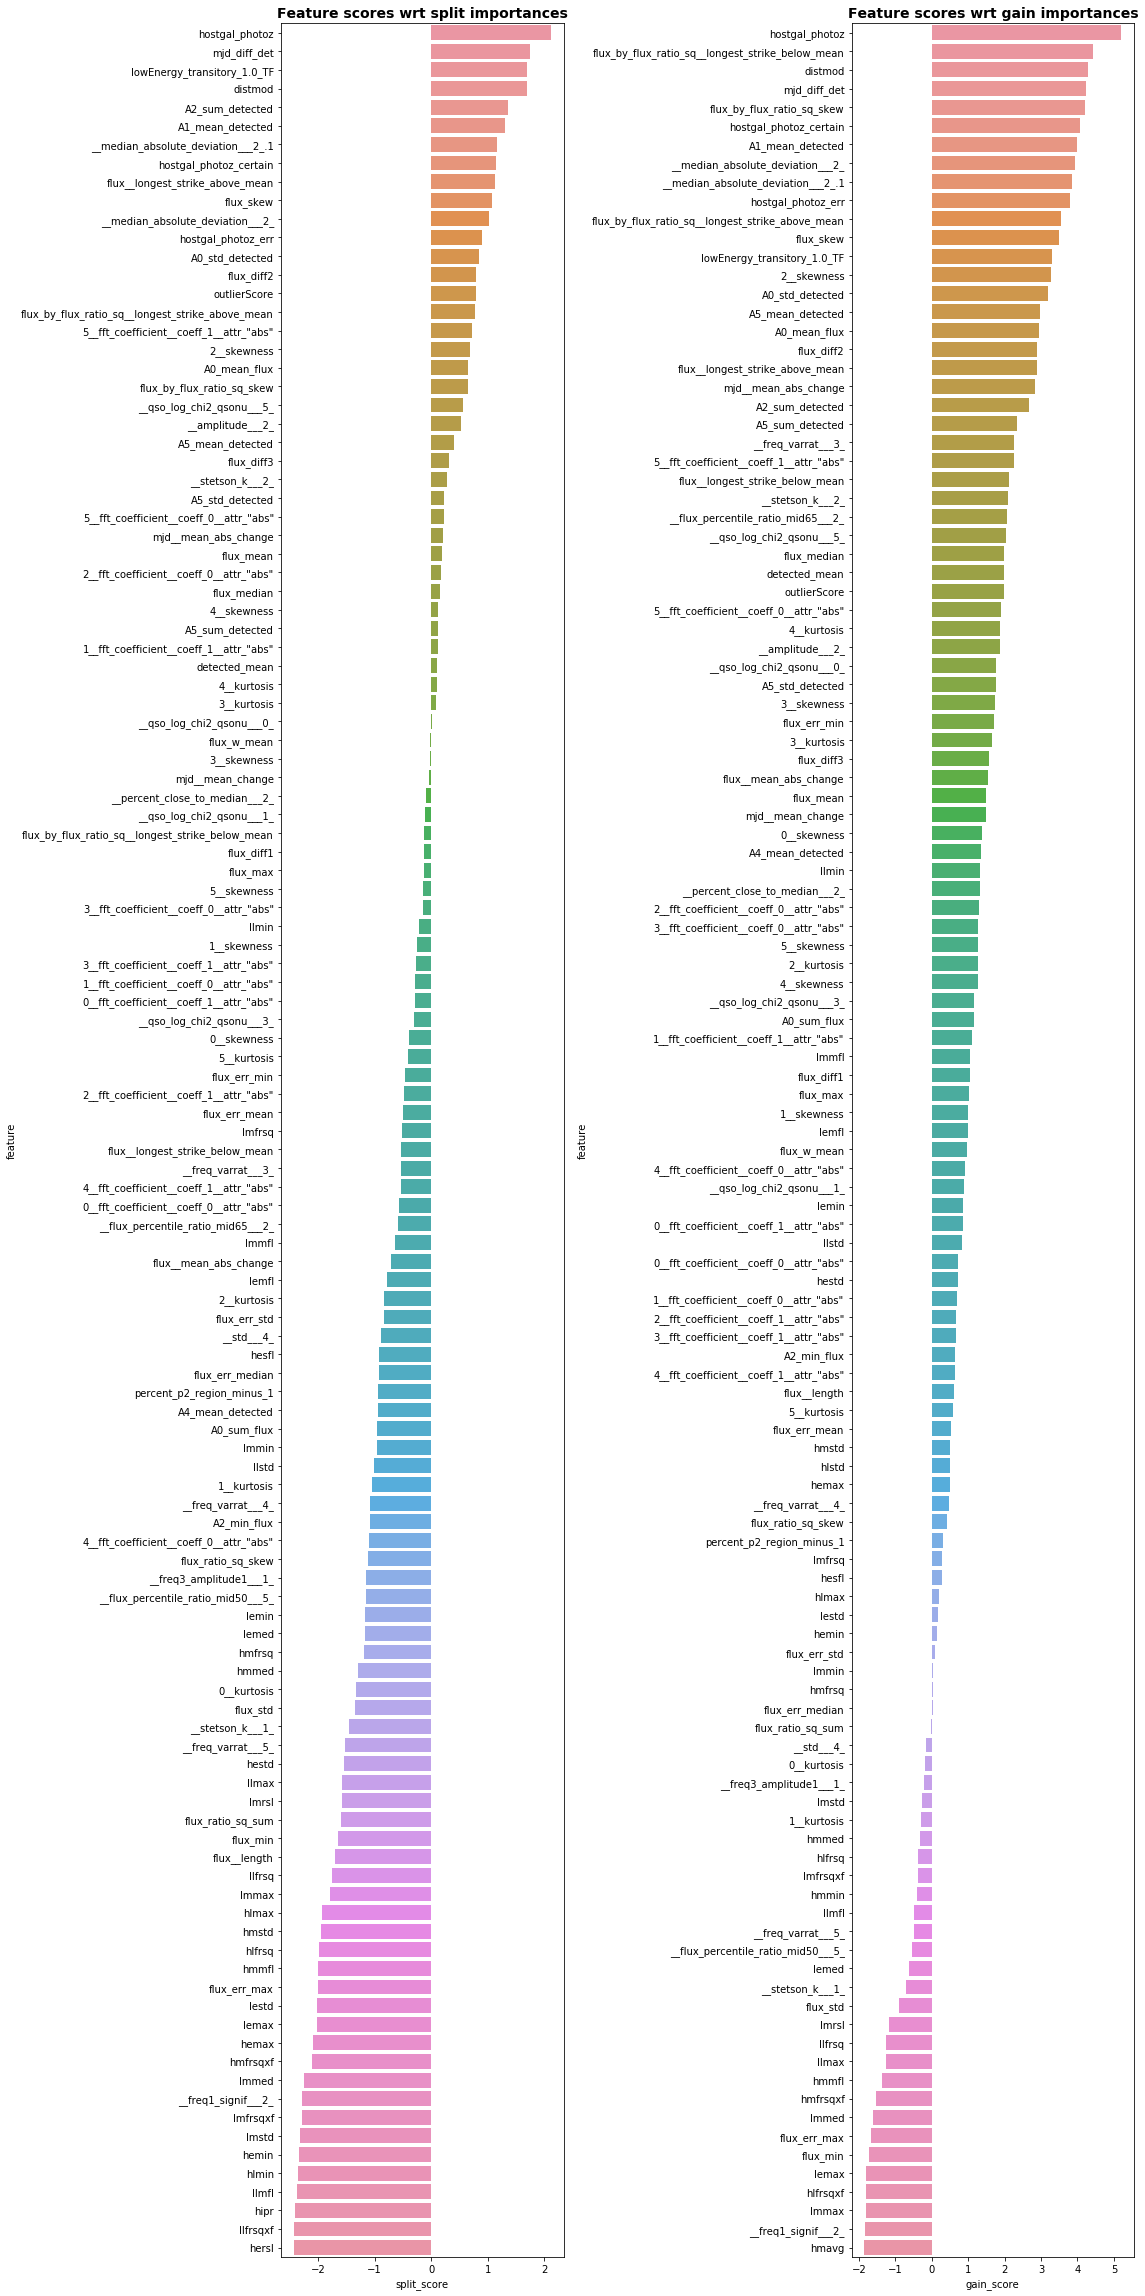

In [34]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 32))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:120], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:120], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [43]:
used_from_train_metadata = ['object_id','lemfl','llstd','llmin','hmstd','lmmfl','hestd','lemin','outlierScore','hemax','hlstd',
'lmfrsq','hesfl','hlmax','hemin','lestd','hmfrsq','lmmin','lmstd','hmmed','hipr','llmfl','hmmin','hlfrsq','lmfrsqxf','lemed',
'highEnergy_transitory_1.0_TF','highEnergy_transitory_1.5_TF', 'lowEnergy_transitory_1.0_TF','lowEnergy_transitory_1.5_TF']

In [44]:
temp[used_from_train_metadata].head()

object_id     lemfl     llstd     llmin     hmstd     lmmfl     hestd  \
0        615  0.264274  0.770807  0.407419  0.557092  0.264653  0.576553   
1        713  0.017125  0.173192  0.919886  0.124637  0.036893  0.082898   
2        730  0.043192  0.324415  1.106755  0.123954  0.048640  0.091184   
3        745  0.003074  0.172586  1.112832  0.306529  0.018975  0.088108   
4       1124  0.047877  0.470323  1.426000  0.082475  0.043202  0.095741   

      lemin  outlierScore     hemax     hlstd    lmfrsq     hesfl     hlmax  \
0  0.432572         0.000  0.820327  0.577139  2.380843  0.141927  0.811806   
1  1.138391         0.875  0.499451  0.066137  1.257270  0.167623  0.153697   
2  1.232450         0.000  0.497219  0.244734  1.456755  0.105791  0.625662   
3  1.181234         0.000  0.502734  0.113672  2.135715  0.148716  0.487101   
4  1.185845         0.375  0.491777  0.322218  1.246681  0.162019  0.700532   

      hemin     lestd    hmfrsq     lmmin     lmstd     hmmed  hipr     llmfl  \
0  1.301038  0.749418  1.261095  0.450530  0.771304  0.921308   1.0  0.237991   
1  2.314684  0.213946  1.202222  1.098708  0.244678  0.785390   2.0  0.014237   
2  2.230497  0.072124  1.352679  1.187092  0.145268  0.710529   1.0  0.004418   
3  2.289767  0.095485  1.701211  1.592998  0.535460  1.101003   1.0  0.023345   
4  2.274372  0.079376  1.159598  1.253987  0.130556  0.857269   1.0  0.080626   

      hmmin    hlfrsq  lmfrsqxf     lemed  highEnergy_transitory_1.0_TF  \
0  1.380625  1.744370  0.489681  0.377550                             0   
1  2.335214  1.554486  0.799570  1.058979                             1   
2  2.222513  1.598755  1.168375  0.711667                             0   
3  3.630944  0.624823  1.396319  1.138718                             0   
4  2.427697  1.536353  0.793698  0.856350                             0   

   highEnergy_transitory_1.5_TF  lowEnergy_transitory_1.0_TF  \
0                             0                            0   
1                             0                            1   
2                             0                            0   
3                             0                            0   
4                             0                            1   

   lowEnergy_transitory_1.5_TF  
0                            0  
1                            1  
2                            0  
3                            0  
4                            0

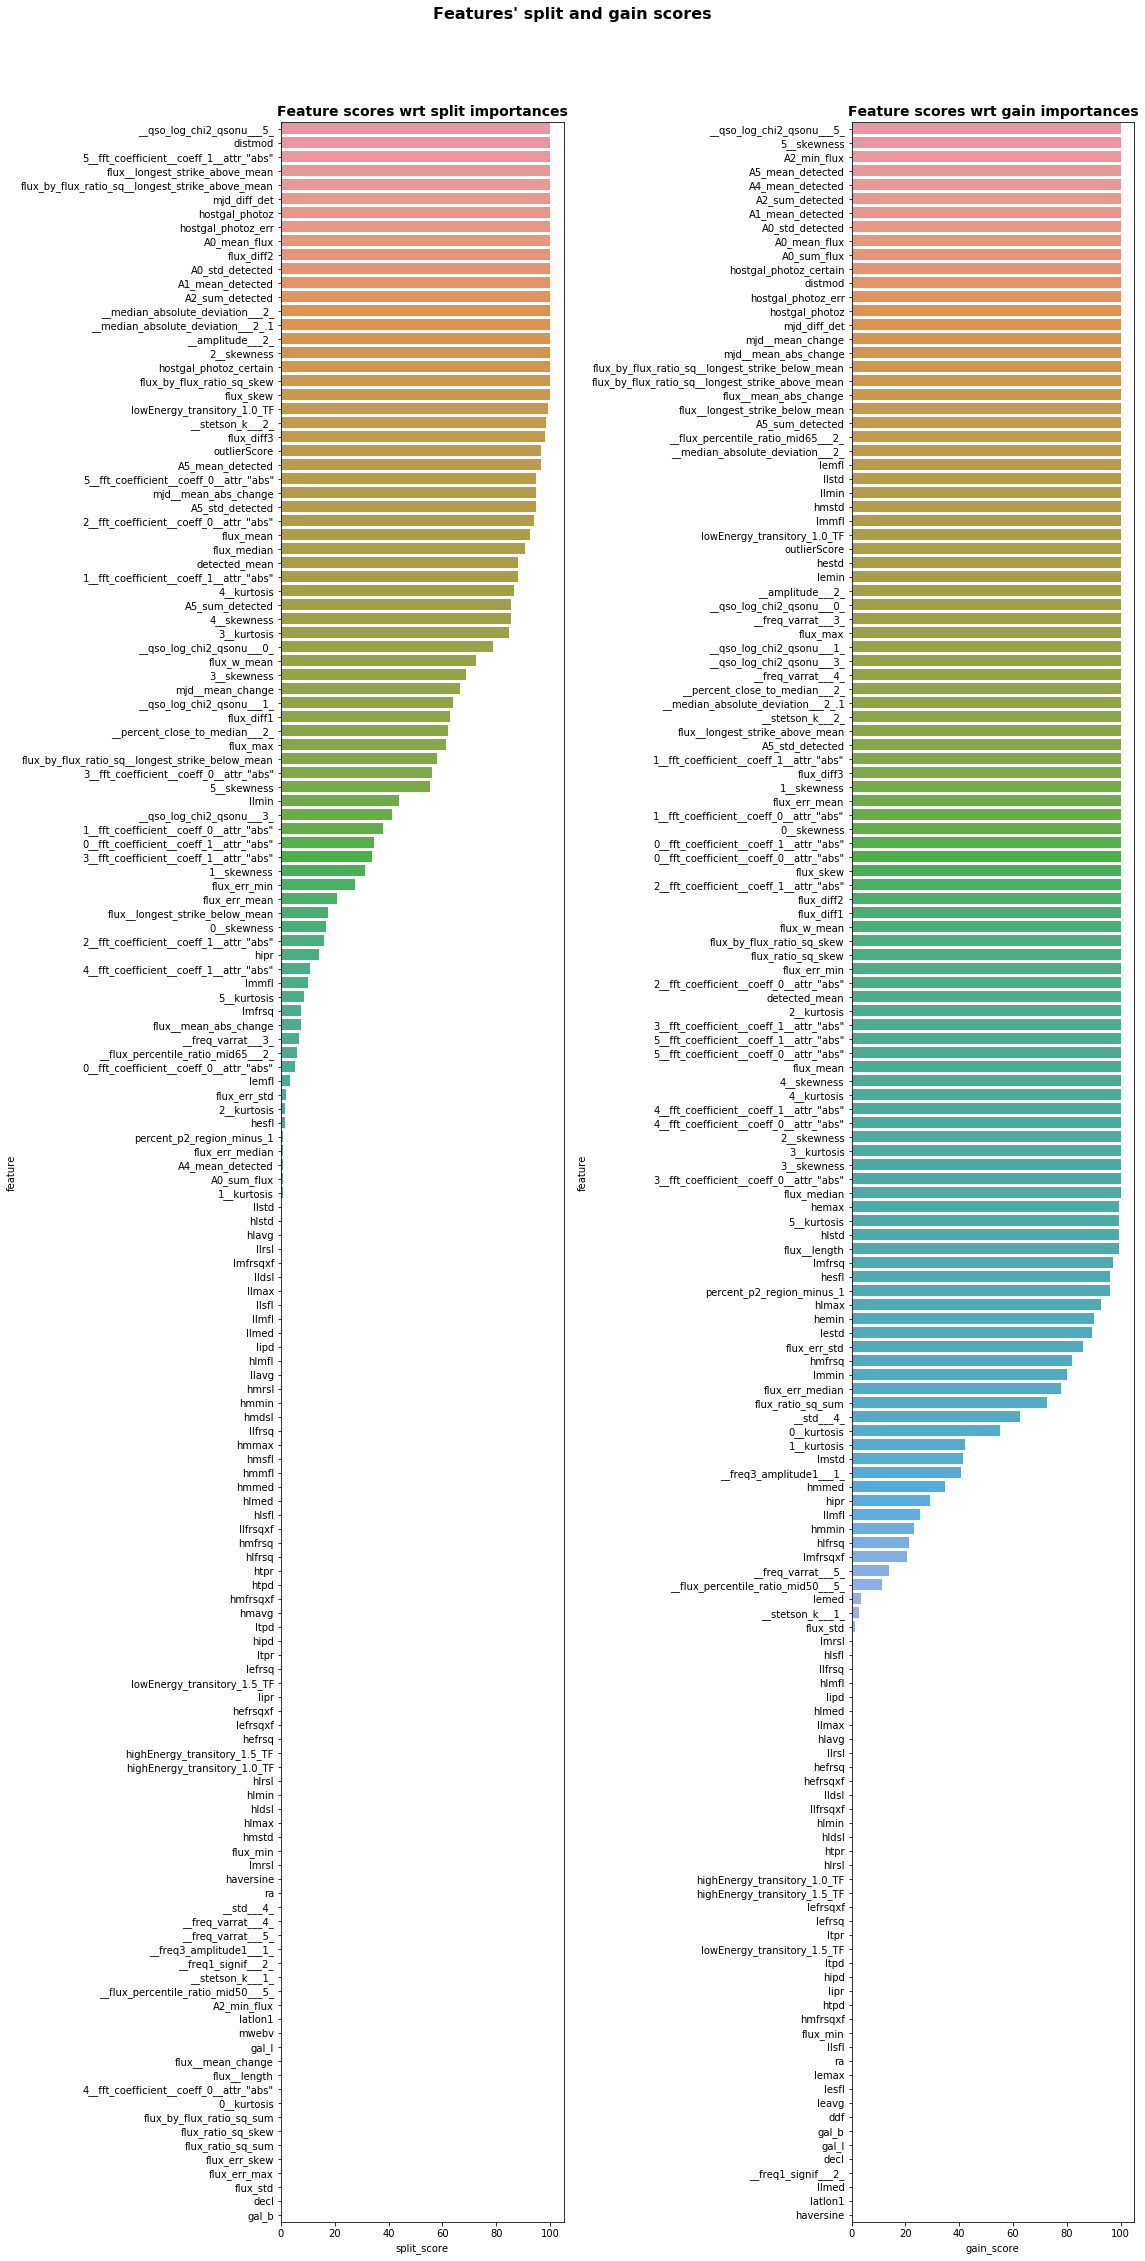

In [38]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 32))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:150], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:150], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [36]:
def score_feature_selection(df=None, train_features=None, target=None):
    
    # Fit LightGBM
    le = preprocessing.LabelEncoder()
    
    target, _ = pd.factorize(df['target'])
    
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
    'random_state':51,
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 250, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75}
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=51
    )
    # Return the last mean / std values 
    return hist['multi_logloss-mean'][-1], hist['multi_logloss-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=temp, train_features=split_feats, target=temp['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=temp, train_features=gain_feats, target=temp['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
	 SPLIT : 0.904358 +/- 0.010780
	 GAIN  : 0.904358 +/- 0.010780
Results for threshold  10
	 SPLIT : 0.902266 +/- 0.010559
	 GAIN  : 0.900721 +/- 0.010398
Results for threshold  20
	 SPLIT : 0.902988 +/- 0.012550
	 GAIN  : 0.901578 +/- 0.011656
Results for threshold  30
	 SPLIT : 0.904259 +/- 0.011420
	 GAIN  : 0.901462 +/- 0.010364
Results for threshold  40
	 SPLIT : 0.906092 +/- 0.010983
	 GAIN  : 0.901710 +/- 0.010294
Results for threshold  50
	 SPLIT : 0.908474 +/- 0.012682
	 GAIN  : 0.902834 +/- 0.011027
Results for threshold  60
	 SPLIT : 0.912154 +/- 0.011471
	 GAIN  : 0.902308 +/- 0.010854
Results for threshold  70
	 SPLIT : 0.912595 +/- 0.011353
	 GAIN  : 0.901629 +/- 0.011065
Results for threshold  80
	 SPLIT : 0.916808 +/- 0.010848
	 GAIN  : 0.901197 +/- 0.010846
Results for threshold  90
	 SPLIT : 0.923619 +/- 0.010958
	 GAIN  : 0.900214 +/- 0.011558
Results for threshold  95
	 SPLIT : 0.930760 +/- 0.010259
	 GAIN  : 0.901397 +/- 0.010864
Results fo